# Volume Edge Detection

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn.functional as F

/home/saba/anaconda3/envs/masters/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
def find_edges(gt, plot = True):
    M_edge = np.zeros((len(gt), len(gt[0])))
    for j in range(len(gt[0]) - 1):
        v_edge = gt[:, j+1] - gt[:, j]
        M_edge[:, j] = v_edge
    if plot:
        plt.subplot(3, 1, 1)
        plt.imshow(gt, interpolation='nearest', aspect='auto')
        plt.xlabel('Time (ms)')
        plt.ylabel('GT channel')
        #x_ticks = np.array([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600])
        x_ticks = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180])
        plt.xticks(ticks = x_ticks, labels = 5*x_ticks)
        #plt.title('Audio File Gammatone Representation')
        plt.subplot(3,1,2)
        plt.imshow(M_edge, interpolation='nearest', aspect='auto')
        plt.xlabel('Time (ms)')
        plt.ylabel('GT channel')
        plt.xticks(ticks = x_ticks, labels = 5*x_ticks)
        #plt.title('Gammatone Edge Detection')
        plt.show()
        plt.subplot(3,1,3)
        classification_over_time('../speech_commands/gammatone/test/gammatone_yesf2e59fea_nohash_1.pkl', raw_wav = False)
        plt.xticks(ticks = 5*x_ticks, labels = 5*x_ticks)
        plt.xlim([0,950])
        """
    edginess = np.sum(M_edge, axis=0)
    if plot:
        plt.plot(range(len(edginess)), edginess)
        plt.title('Discontinuities Over Time')
        plt.xlabel('Time (steps)')
        plt.ylabel('Magnitude of Discontinuity')
        plt.show()
        plt.hist(edginess)
        plt.title('Distribution of Discontinuity')
        plt.xlabel('Magnitude of Discontinuity')
        plt.ylabel('Number of Time Increments')
        plt.show()
    return edginess"""

#audio_set = pickle.load(open('../audio_lstm/gammatone/' + 'dog_gammatone.pkl', "rb"))
audio_set = pickle.load(open('../speech_commands/gammatone/' + 'test/gammatone_yesf2e59fea_nohash_1.pkl', "rb"))
example_gt = audio_set[0]
find_edges(example_gt)

In [13]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Experimental(nn.Module):
    def __init__(self, encode_size, hidden_size, n_tgt_class):
        """
        Args:
          encode_size: The size of the (encoded) spectral input
          hidden_size: The number of features in the hidden state of GRU.
        """
        super(Experimental, self).__init__()
        self.hidden_size = hidden_size
        self.n_tgt_class = n_tgt_class
        self.gru = nn.GRU(input_size=encode_size, hidden_size=hidden_size)
                            #device = device)

    def forward(self, src_pad, src_lengths):
        """
        Args:
          src_pad of shape (max_src_seq_length, batch_size, encoding_size): Tensor of padded src sequences.
          src_lengths: List of source sequence lengths.

        Returns:
          outputs of shape (max_src_seq_length, batch_size, hidden_size): Padded outputs of GRU at every step.
          hidden of shape (1, batch_size, hidden_size): Updated states of the GRU.
        """
        
        packed = pack_padded_sequence(src_pad, src_lengths)
        output, hidden = self.gru(packed)
        output = pad_packed_sequence(output)
        probs = hidden[:,:,-self.n_tgt_class:].to(device)
        return probs, hidden, output[0]

def load_model(model, filename, device):
    model.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    print('Model loaded from %s.' % filename)
    model.to(device)
    model.eval()
    
encode_size = 256
hidden_size = 256
#tgt_classes = ['Human_voice', 'Glass']
tgt_classes = ['yes', 'no']
n_tgt_class = len(tgt_classes)

device = torch.device('cpu')
experimental = Experimental(encode_size, hidden_size, n_tgt_class).to(device)
load_model(experimental, 'gru_experimental_yes_no.pth', device)

Model loaded from gru_experimental_yes_no.pth.


In [4]:
from torch.nn.utils.rnn import pad_sequence

padding_value = 0

def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (src_seq, tgt_cat):
          src_seq is of shape (src_seq_length,)
          tgt_cat is list of class indices

    Returns:
      src_pad of shape (max_src_seq_length, batch_size, encoding_size): Tensor of padded src sequences.
          The sequences should be sorted by length in a decreasing order, that is src_pad[:,0,:] should be
          the longest sequence, and src_pad[:,-1,:] should be the shortest.
      src_seq_lengths: List of lengths of src sequences.
      tgt_cats of shape (batch_size, n_class): Tensor of target categories' probabilities.
    """
    
    #print('sample size: ' + str(list_of_samples[0][0].size()))
    sortSamples = sorted(list_of_samples, key = lambda x: x[0].size(0), reverse = True)
    
    #figure out max lengths and src_seq_lengths list
    src_seq_lengths = []
    for seq in sortSamples:
        src_seq_lengths.append(seq[0].size(0))
    max_src_seq_length = src_seq_lengths[0]
    #print(src_seq_lengths)
    
    #padding loop
    src_pad = None
    tgt_cats = None
    file_paths = []
    primer_lens = []
    
    for seq in sortSamples:
        src_pad_len = max_src_seq_length - seq[0].size(0)
        pad_src_seq = F.pad(seq[0], (0, 0, 0, src_pad_len), value = padding_value).unsqueeze(0).to(device)
        if src_pad is None:
            src_pad = pad_src_seq
        else:
            src_pad = torch.cat([src_pad, pad_src_seq], 0).to(device)
        
        file_paths.append(seq[2])
        primer_lens.append(seq[3])
            
    return src_pad.permute(1, 0, 2), src_seq_lengths, file_paths, primer_lens

In [21]:
from scipy.io import wavfile
import gammatone.gtgram as gtg
from torch.utils.data import DataLoader

def getAudioGammatone(path, plot = True):
    print('Processing ' + path)
    fs, data = wavfile.read(path)
    gram = gtg.gtgram(data, fs, 0.1, 0.01, encode_size, 20)
    np_M = np.array(gram)
    np_M = np.clip(np_M, 1.0, 1000000.0)
    log_M = np.log(np_M)
    max_M = max(log_M.flatten())
    M = log_M / max_M
    if plot:
        plt.imshow(M, interpolation='nearest', aspect='auto')
        plt.show()
    return (M, 0)

def loadGammatone(path):
    gt = pickle.load(open(path, "rb"))
    return gt

def plotClassification(filename):
    _, _, output = experimental.forward(src_batch, seq_lengths)
    print(output)
    
def squeeze_tgts(numerical_labels, tgt_classes, class_dict):
    filtered_labels = []
    for i, label in enumerate(tgt_classes):
        if class_dict[label] in numerical_labels:
            filtered_labels.append(i)
    return filtered_labels

class DummyDataset(Dataset):
    def __init__(self, gt, gt_primer = None):
        self.len = 1
        self.gt = gt
        self.gt_primer = gt_primer
                        
    def __len__(self):
        return self.len
        
    def __getitem__(self, idx):
        M = torch.tensor(self.gt[0]).permute(1,0).float().to(device)
        #print('M size: '+ str(M.size()))
        primer_len = 0
        if self.gt_primer is not None:
            M_primer = torch.tensor(self.gt_primer[0]).permute(1,0).float().to(device)
            M = torch.cat((M_primer, M), dim=0)
            primer_len = M_primer.size(0)
        #print('M + M_primer size: ' + str(M.size()))
        #print('primer len: ' + str(primer_len))
        item = (M, [self.gt[1]], 'dummy', primer_len)
        #print("fetching tensor of size " + str(item[0].size()) + " and class " + str(gt[1]))
        return item
    
def classification_over_time(path, plot = True, raw_wav = True, priming_file = None):
    gt = None
    gt_primer = None
    if raw_wav:
        gt = getAudioGammatone(path, plot)
    else:
        gt = loadGammatone(path)
        if priming_file is not None:
            gt_primer = loadGammatone(priming_file)
            
    dummyset = DummyDataset(gt, gt_primer)
    dummyloader = DataLoader(dataset=dummyset, batch_size=1, shuffle=False, collate_fn=collate, pin_memory=False)
    src, seq_len, _, primer_len = next(iter(dummyloader))
    _, _, output = experimental.forward(src, seq_len)
    output = output.squeeze(1)
    #print(primer_len)
    t_class = output[primer_len[0]:, -n_tgt_class:]
    t = range(0, 5*len(t_class), 5)
    t_class = t_class.cpu().detach().numpy()
    if plot:
        for i in range(n_tgt_class):
            label = tgt_classes[i]
            if i%2 == 1:
                linestyle = 'solid'
            else:
                linestyle = '--'
            plt.plot(t, t_class[:,i], label = label, linestyle = linestyle)
        #plt.title('Classification Over Time for Audio Sample')
        plt.xlabel('Time (ms)')
        plt.ylabel('Classification')
        plt.legend()
        plt.show()
    return t_class, gt[0]

#classification_over_time('./180300.wav')
classification_over_time('../speech_commands/gammatone/test/gammatone_yesf2e59fea_nohash_1.pkl', raw_wav = False)

(array([[ 0.02296118,  0.01219475],
        [-0.14223348, -0.02661239],
        [-0.33451772,  0.0075517 ],
        [-0.41963774, -0.04757882],
        [-0.43681616, -0.1443263 ],
        [-0.44655925, -0.170645  ],
        [-0.45540342, -0.15063359],
        [-0.46353576, -0.11544262],
        [-0.4711229 , -0.07593047],
        [-0.47827643, -0.03544644],
        [-0.48506942,  0.0048022 ],
        [-0.49155727,  0.04424891],
        [-0.4977835 ,  0.08259599],
        [-0.503785  ,  0.11961891],
        [-0.50959307,  0.155128  ],
        [-0.51523304,  0.18903422],
        [-0.5207262 ,  0.22130585],
        [-0.5260898 ,  0.2519551 ],
        [-0.5313353 ,  0.28114885],
        [-0.53647166,  0.3090726 ],
        [-0.5415107 ,  0.33569288],
        [-0.5464616 ,  0.3610767 ],
        [-0.55132985,  0.38535956],
        [-0.5561213 ,  0.4085848 ],
        [-0.5608393 ,  0.43090674],
        [-0.56549233,  0.45214906],
        [-0.5700885 ,  0.472205  ],
        [-0.57462883,  0.491

In [6]:
def future_classification(path, track_class, priming_file = None, sample_max_t = 0, plot=True, raw_wav = True):
    t_class, M_gt = classification_over_time(path, plot, raw_wav, priming_file)
    max_t = max(len(t_class), sample_max_t)
    fut_classif = np.zeros((len(t_class), max_t))
    track_class_id = tgt_classes.index(track_class)
    for i in range(len(t_class)-1):
        remain_time_series = t_class[i+1:,track_class_id]
        end_state_series = t_class[-1,track_class_id] * np.ones((max_t - len(t_class) +i+1))
        fut_classif[i,:] = np.concatenate((remain_time_series, end_state_series))
    fut_classif[len(t_class)-1, :] = t_class[-1,track_class_id] * np.ones(max_t)
    if plot:
        plt.imshow(fut_classif, interpolation='nearest', aspect='auto')
        plt.xlabel('future classification')
        plt.ylabel('current time')
        plt.show()
    edginess = find_edges(M_gt, plot=plot)
    sort_idx = np.argsort(edginess)
    #edg_sorted_fut_classif = np.zeros((len(t_class), len(t_class)))
    edg_sorted_fut_classif = fut_classif[tuple(sort_idx), :]
    if plot:
        plt.imshow(edg_sorted_fut_classif, interpolation='nearest', aspect='auto')
        plt.xlabel('future classification')
        plt.ylabel('edge strength rank')
        plt.show()
    return edg_sorted_fut_classif

In [7]:
from scipy.signal import convolve2d
import math

def fuzzyResizeSquareMatrix(M, tgt_sz):
    n_M = np.shape(M)[0]
    n_scale = 0
    if n_M % tgt_sz == 0:
        n_scale = int(n_M / tgt_sz)
    else:
        n_scale = math.ceil(n_M / tgt_sz)
    
    kernel = np.ones((n_scale, 1)) / n_scale
    M_convol = convolve2d(M, kernel, mode = 'same', boundary = 'symm') #used for smoothing out the matrix
    
    indices = []
    for i in range(tgt_sz):
        sample_ratio = i / tgt_sz
        sample_idx = math.floor(sample_ratio * n_M)
        indices.append(sample_idx)
        
    M_rows = M_convol[indices, :]
    
    return M_rows

{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 32, 'wow': 33, 'yes': 34, 'zero': 35}
[34, 18]
[18]
no


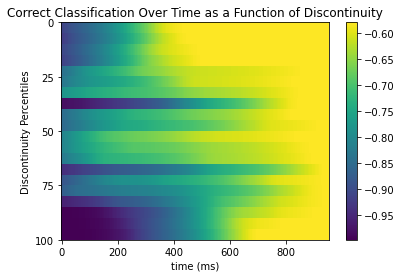

[18]
no


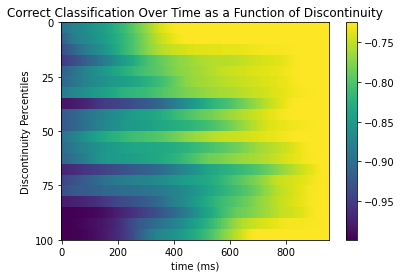

[34]
[34]
[34]
[34]
[18]
no


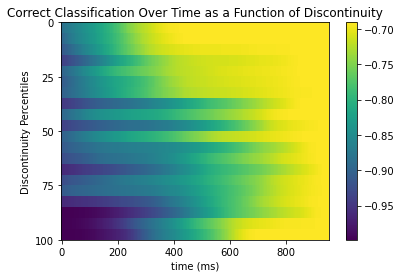

[34]
[34]
[18]
no


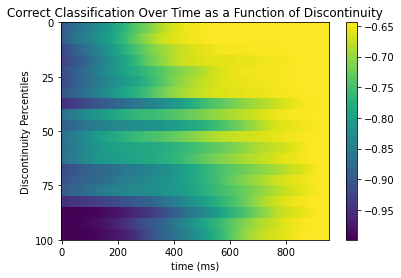

[34]
[18]
no


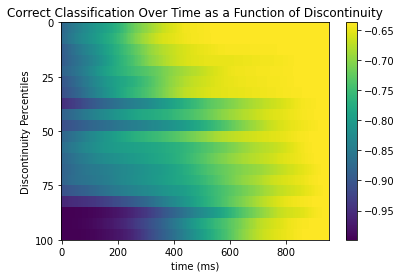

[34]
[18]
no


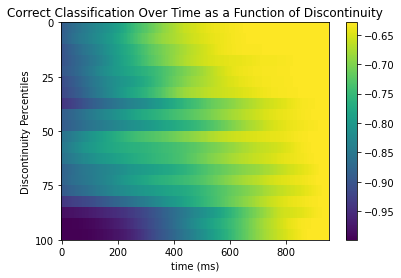

[18]
no


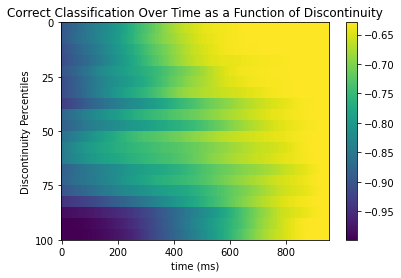

[18]
no


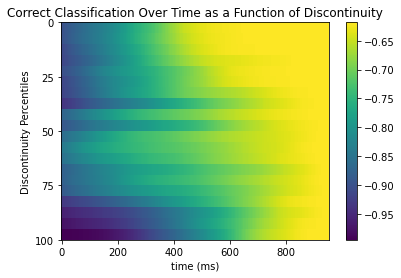

[18]
no


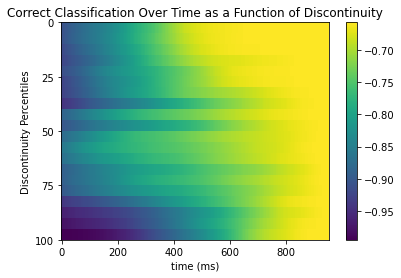

[18]
no


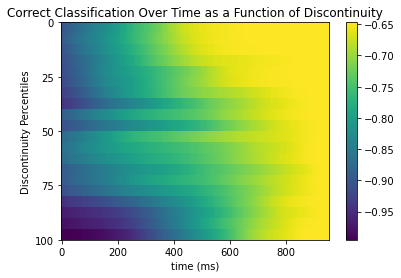

[34]
[34]
[34]
[18]
no


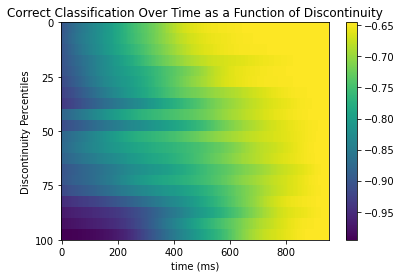

[18]
no


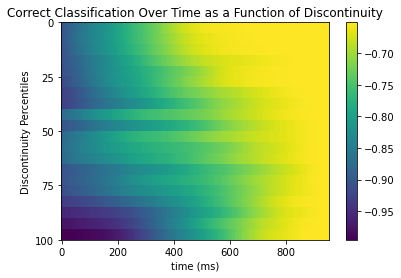

[18]
no


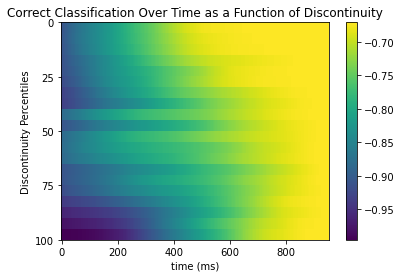

[34]
[18]
no


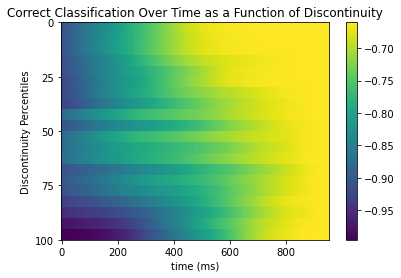

[18]
no


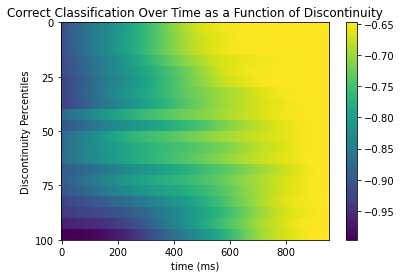

[34]
[34]
[18]
no


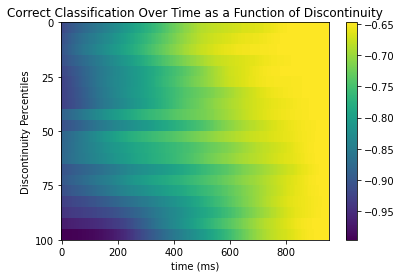

[34]
[34]
[18]
no


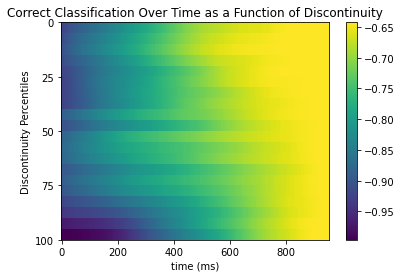

[18]
no


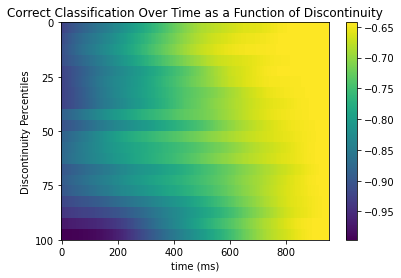

[18]
no


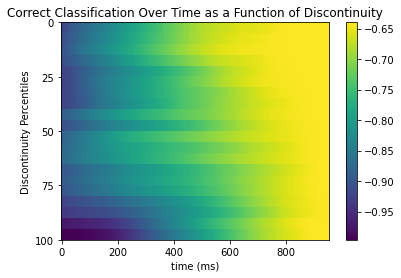

[34]
[18]
no


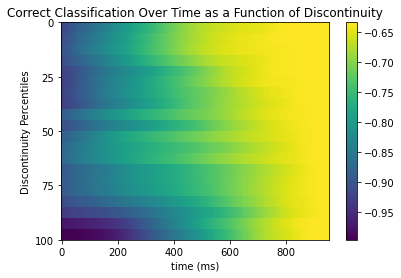

[18]
no


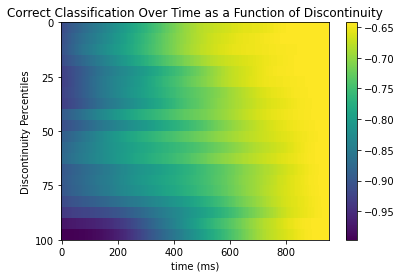

[18]
no


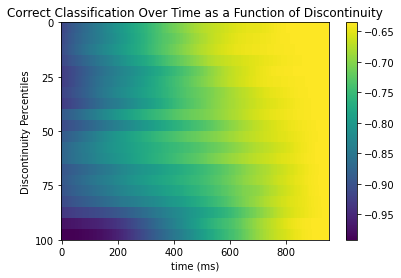

[34]
[34]
[18]
no


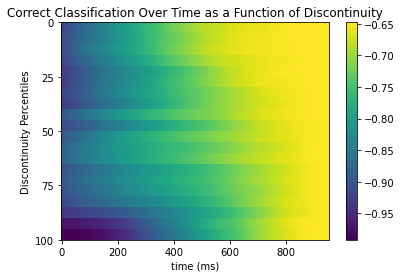

[34]
[18]
no


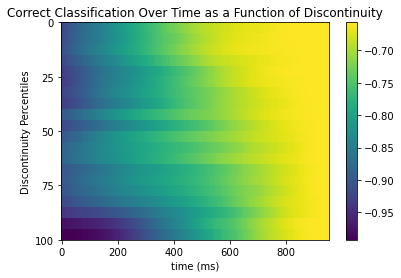

[34]
[34]
[34]
[34]
[34]
[34]
[18]
no


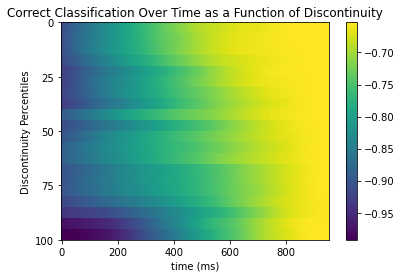

[34]
[18]
no


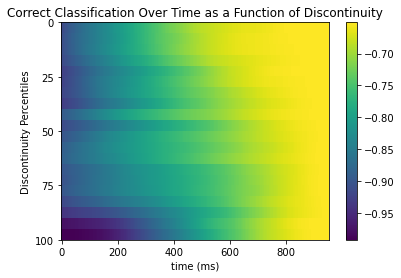

[34]
[18]
no


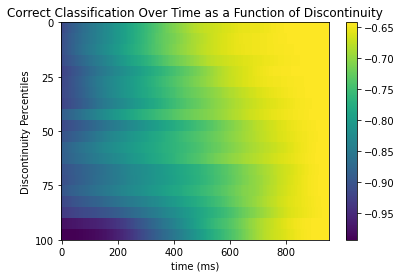

[34]
[34]
[34]
[18]
no


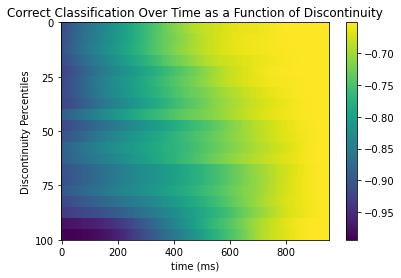

[18]
no


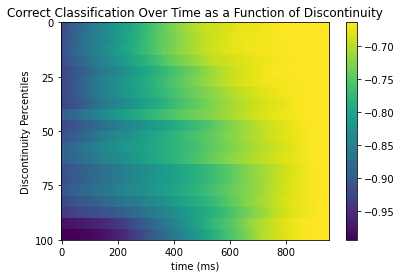

[34]
[34]
[18]
no


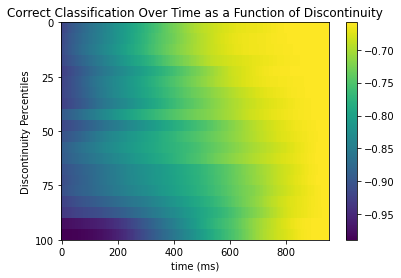

[18]
no


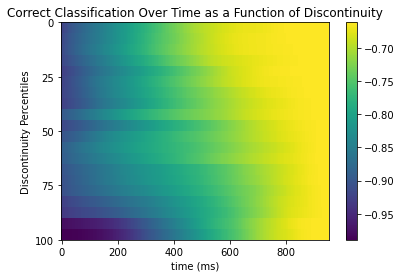

[18]
no


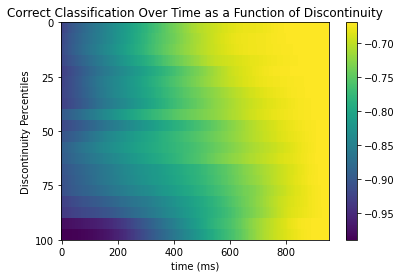

[34]
[18]
no


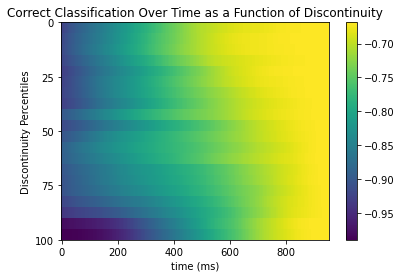

[34]
[34]
[34]
[34]
[34]
[34]
[34]
[18]
no


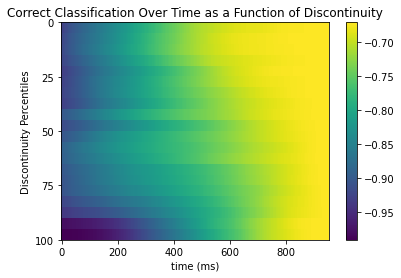

[18]
no


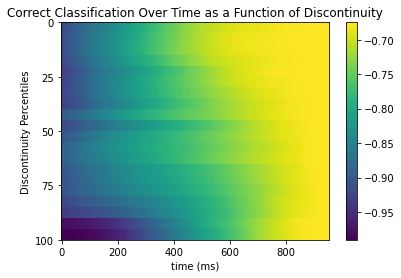

[18]
no


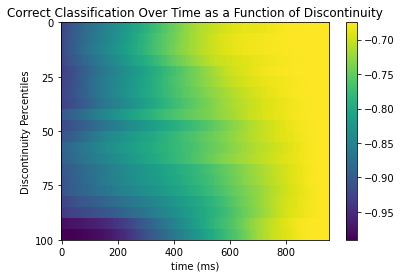

[34]
[18]
no


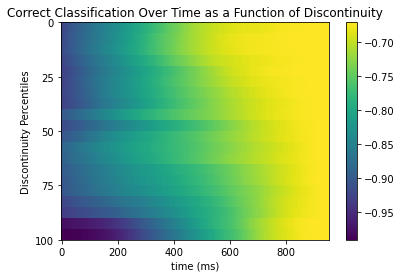

[34]
[18]
no


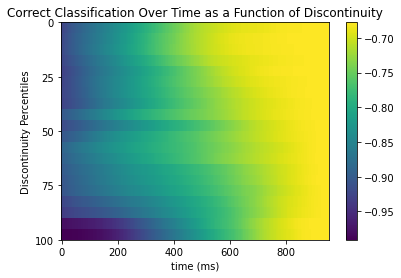

[34]
[18]
no


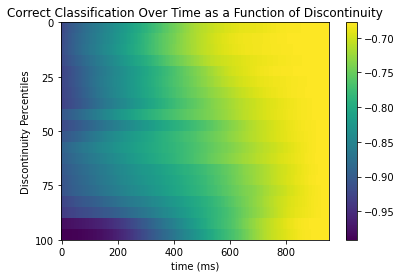

[18]
no


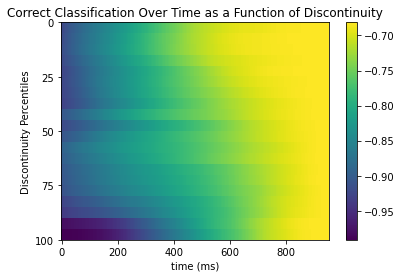

[34]
[34]
[34]
[34]
[34]
[18]
no


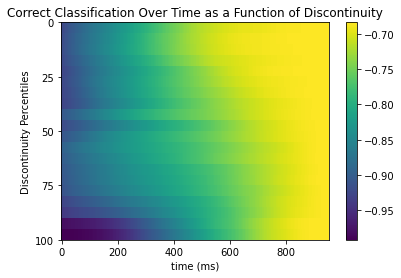

[34]
[18]
no


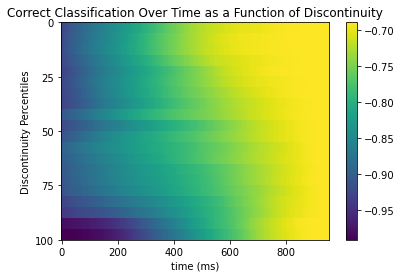

[34]
[34]
[18]
no


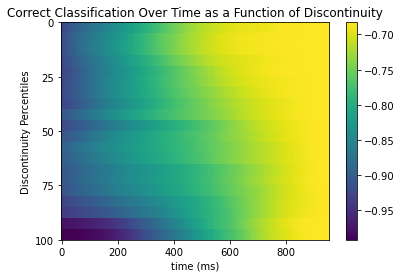

[18]
no


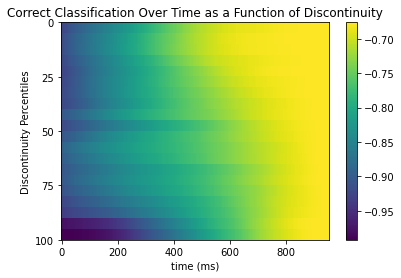

[18]
no


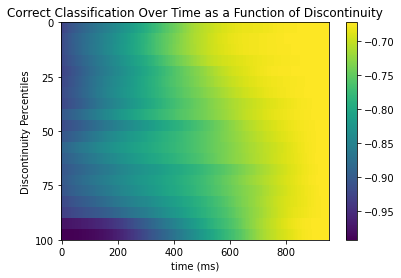

[34]
[34]
[34]
[34]
[34]
[18]
no


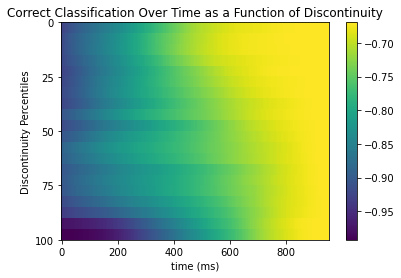

[34]
[18]
no


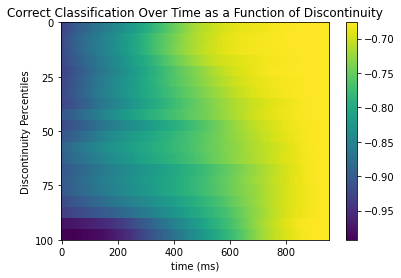

[18]
no


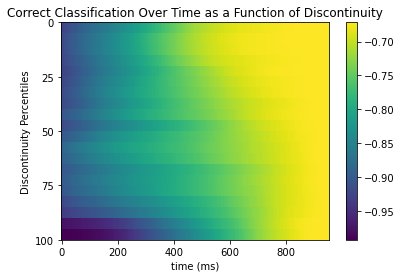

[18]
no


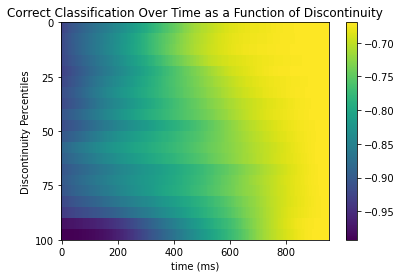

[18]
no


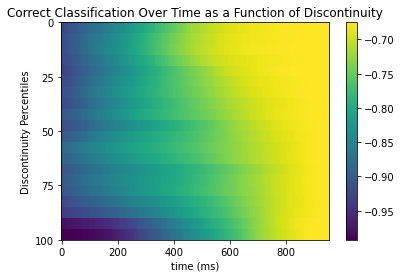

[34]
[18]
no


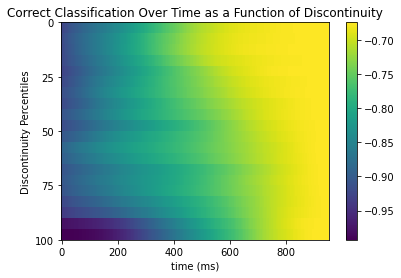

[34]
[18]
no


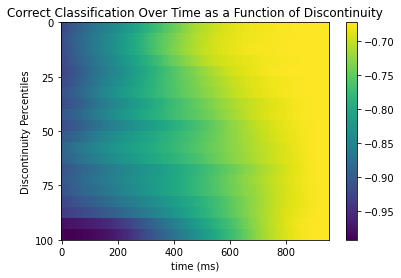

[18]
no


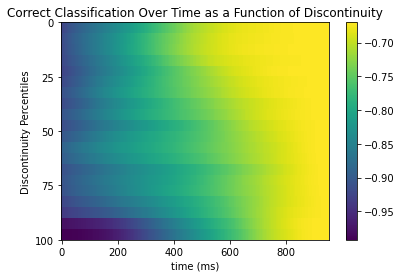

[18]
no


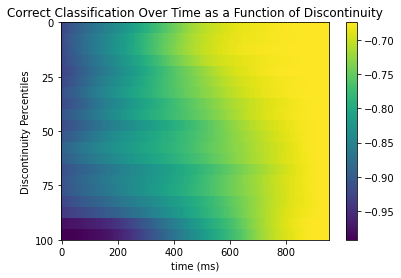

[34]
[34]
[34]
[18]
no


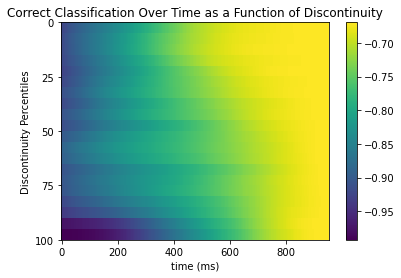

[34]
[34]
[18]
no


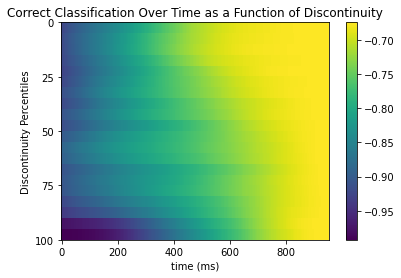

[18]
no


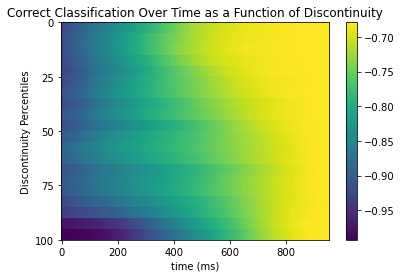

[18]
no


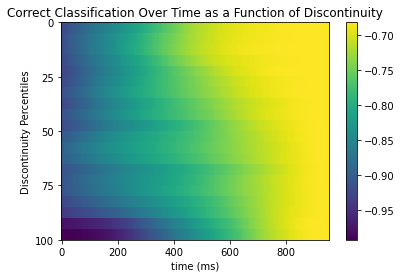

[34]
[18]
no


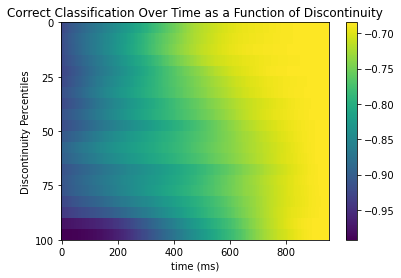

[34]
[18]
no


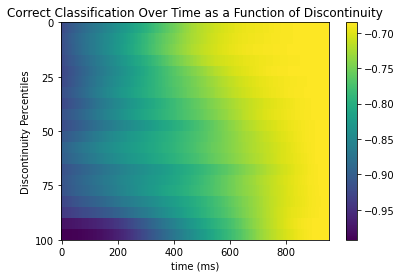

[34]
[34]
[34]
[18]
no


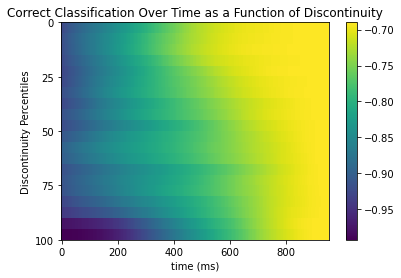

[34]
[34]
[34]
[18]
no


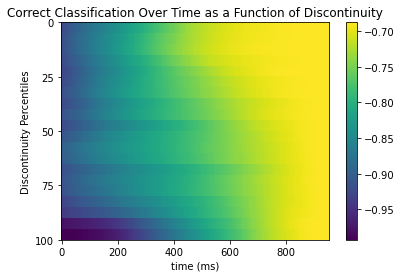

[18]
no


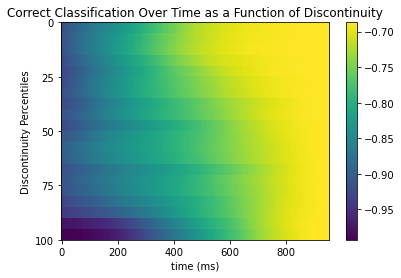

[34]
[18]
no


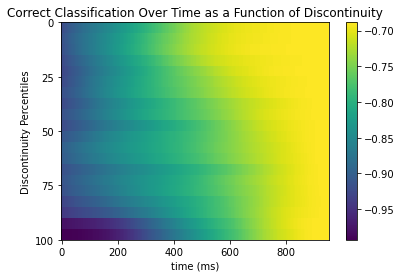

[18]
no


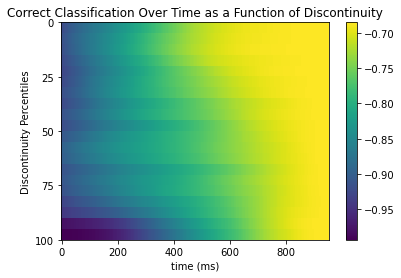

[18]
no


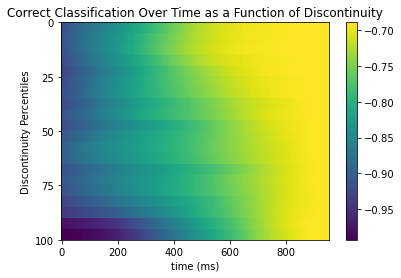

[34]
[18]
no


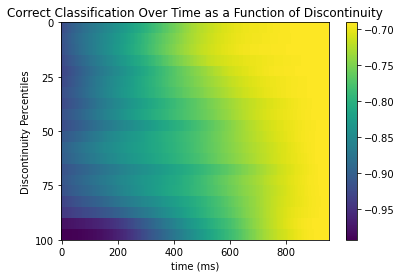

[34]
[34]
[18]
no


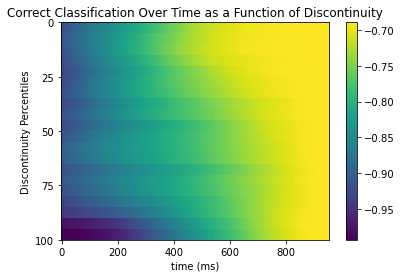

[18]
no


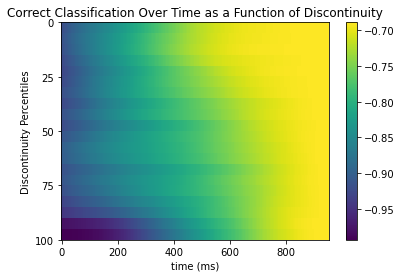

[34]
[34]
[34]
[18]
no


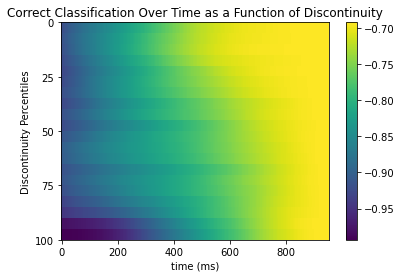

[18]
no


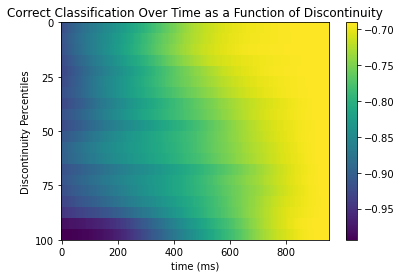

[34]
[18]
no


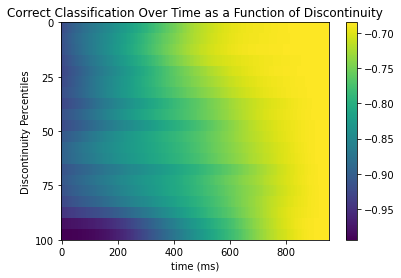

[34]
[18]
no


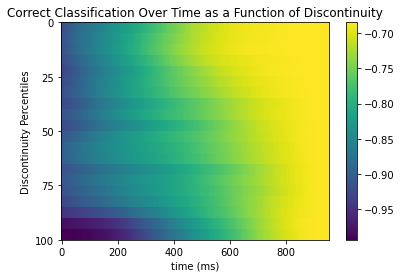

[18]
no


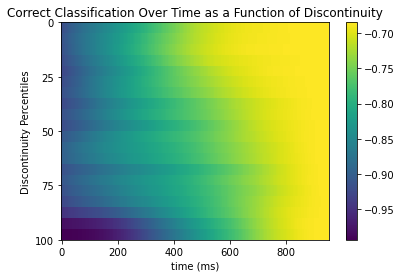

[18]
no


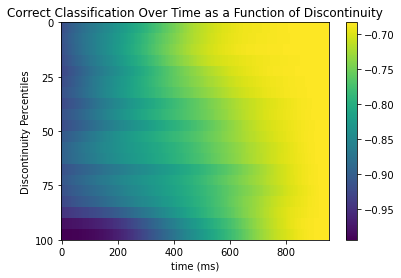

[18]
no


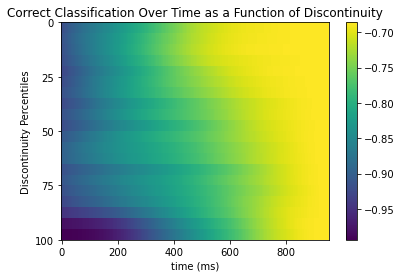

[34]
[18]
no


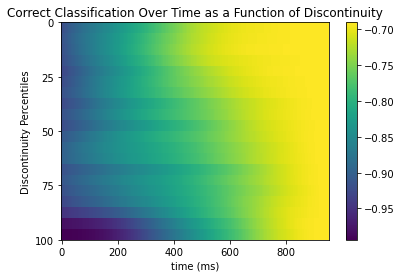

[34]
[18]
no


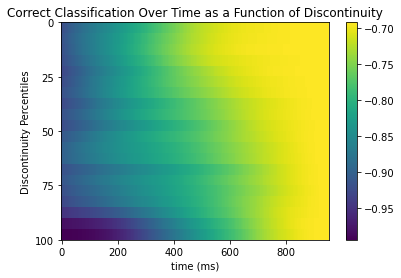

[18]
no


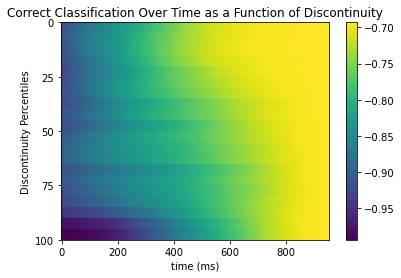

[18]
no


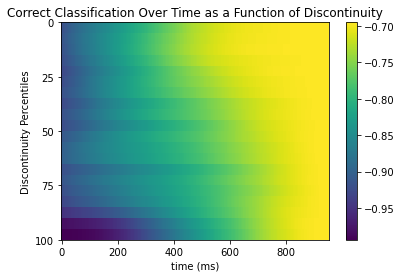

[34]
[34]
[18]
no


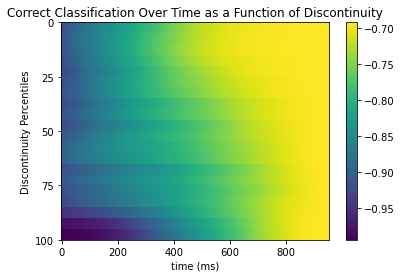

[18]
no


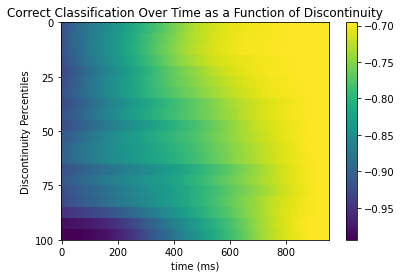

[34]
[18]
no


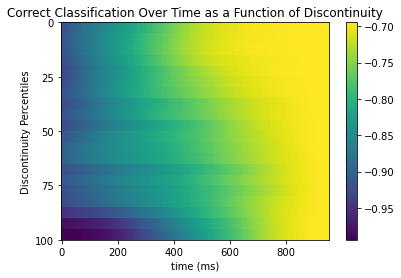

[34]
[18]
no


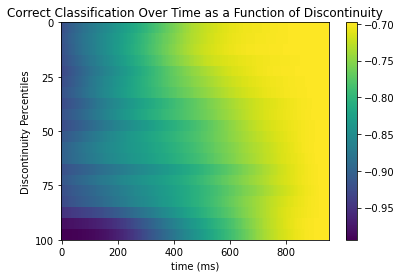

[34]
[34]
[18]
no


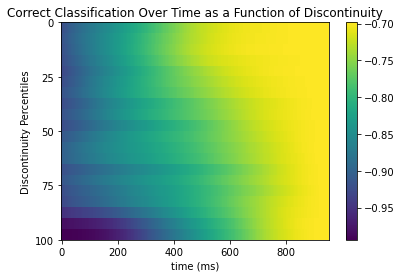

[18]
no


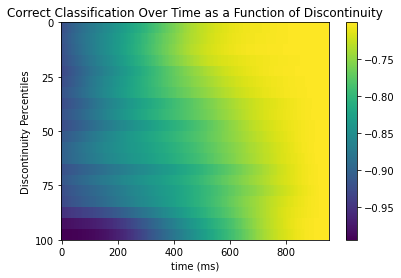

[18]
no


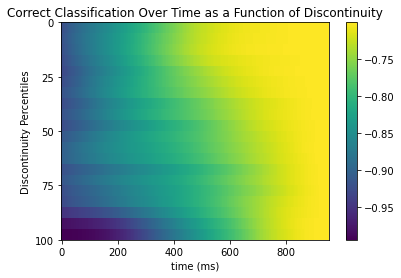

[18]
no


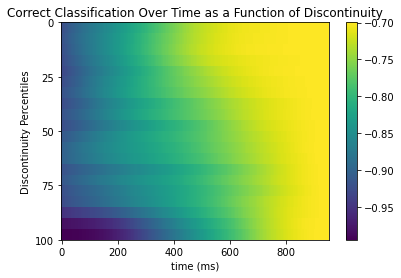

[34]
[18]
no


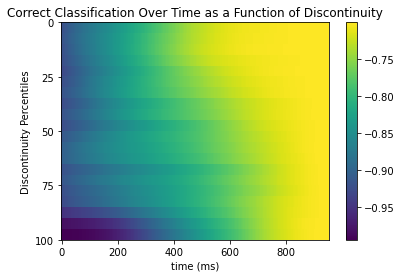

[34]
[18]
no


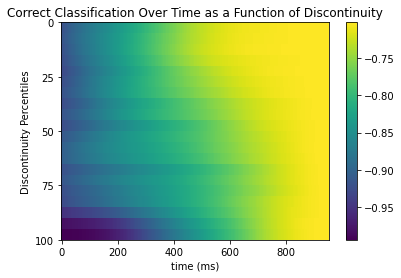

[18]
no


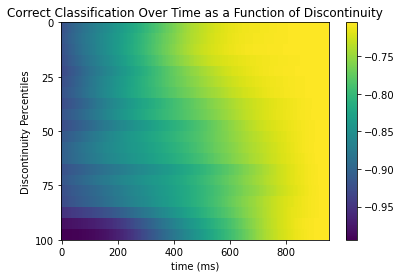

[34]
[18]
no


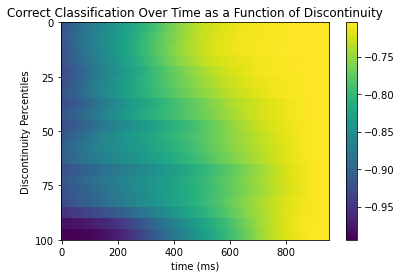

[34]
[18]
no


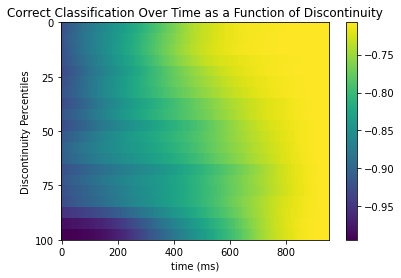

[34]
[34]
[34]
[18]
no


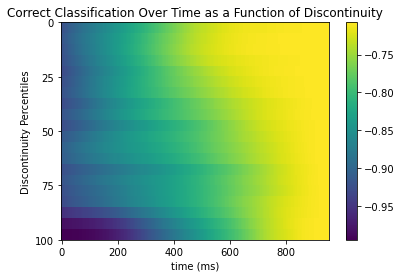

[34]
[18]
no


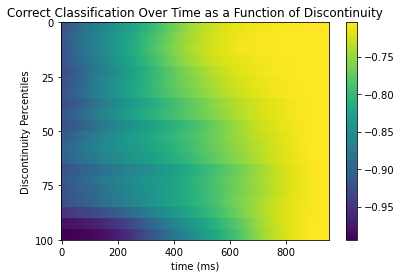

[18]
no


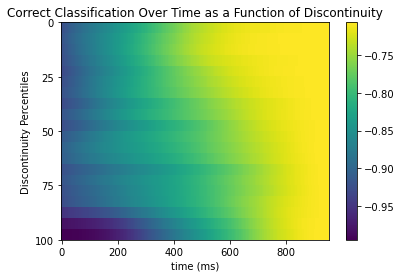

[18]
no


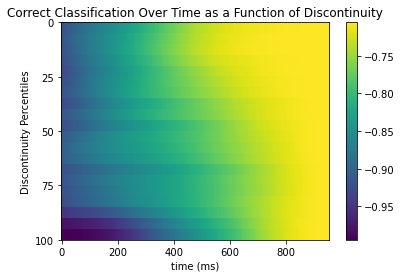

[34]
[34]
[34]
[18]
no


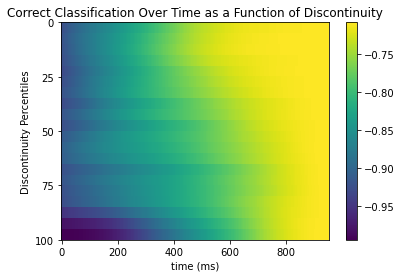

[34]
[34]
[34]
[34]
[34]
[18]
no


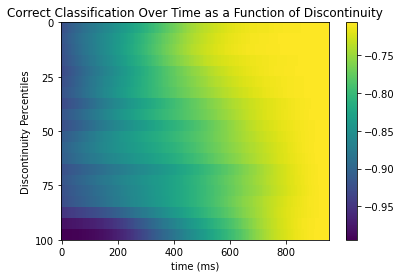

[34]
[18]
no


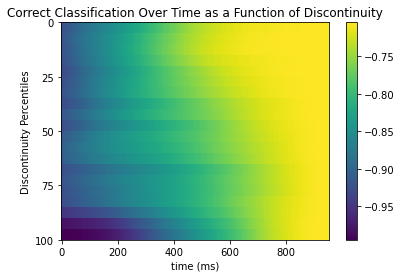

[18]
no


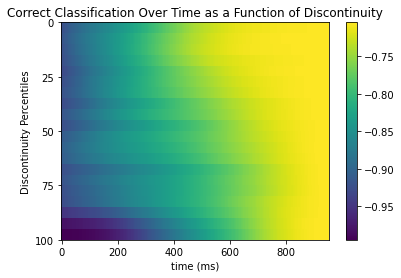

[18]
no


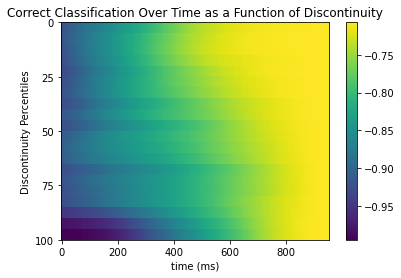

[34]
[34]
[34]
[34]
[34]
[34]
[18]
no


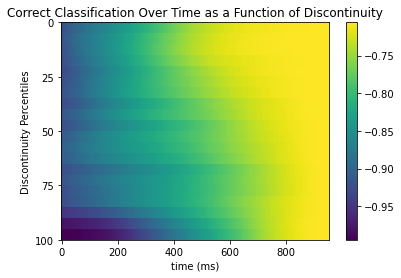

[18]
no


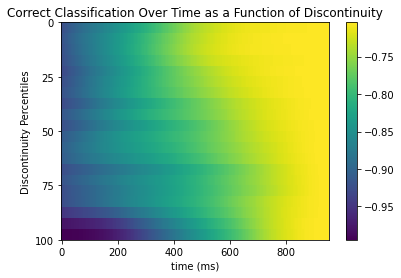

[18]
no


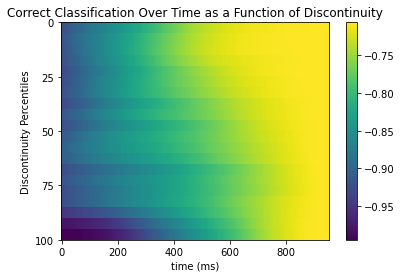

[18]
no


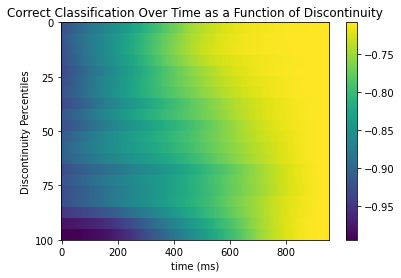

[18]
no


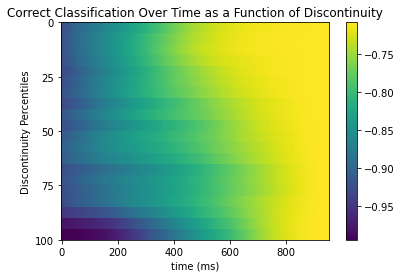

[34]
[34]
[18]
no


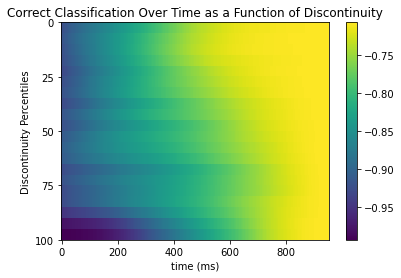

[18]
no


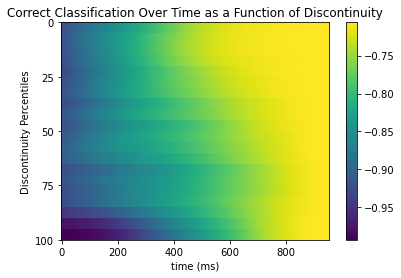

[34]
[34]
[18]
no


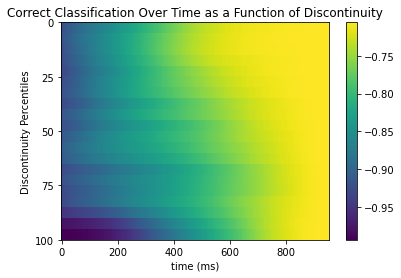

[18]
no


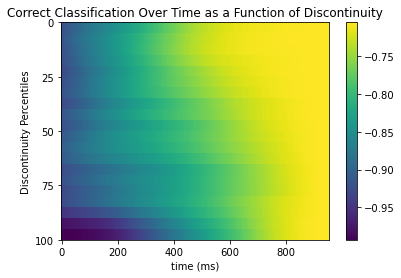

[34]
[34]
[18]
no


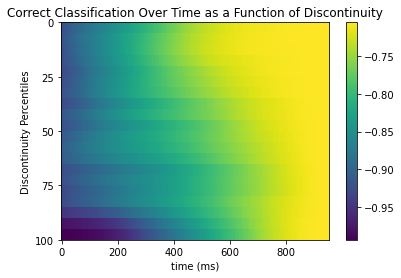

[34]
[34]
[18]
no


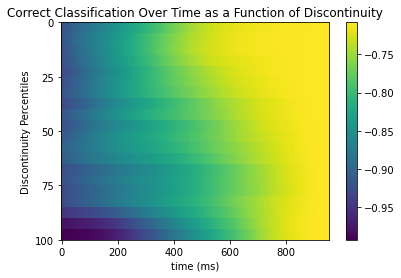

[18]
no


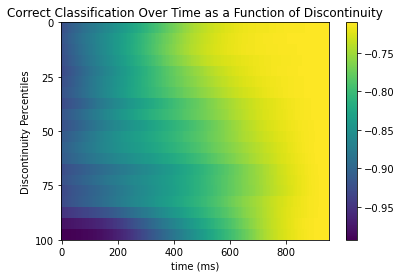

[34]
[18]
no


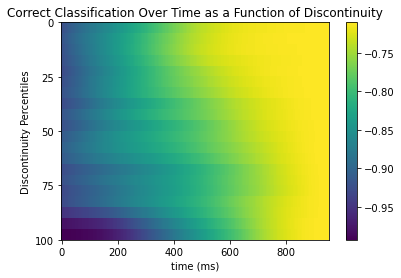

[34]
[18]
no


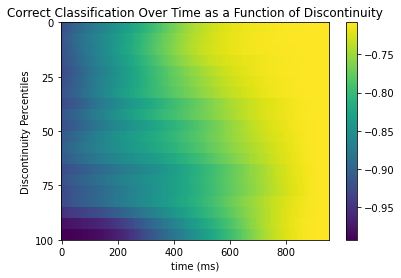

[34]
[34]
[18]
no


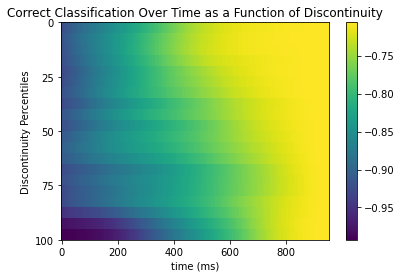

[18]
no


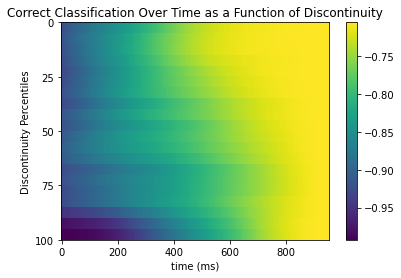

[34]
[18]
no


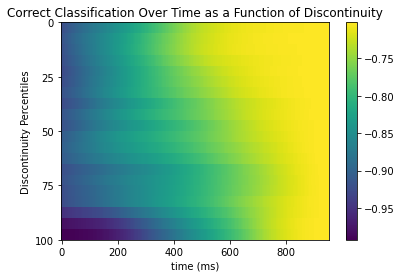

[34]
[18]
no


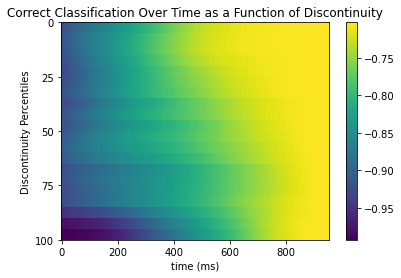

[34]
[34]
[34]
[34]
[34]
[18]
no


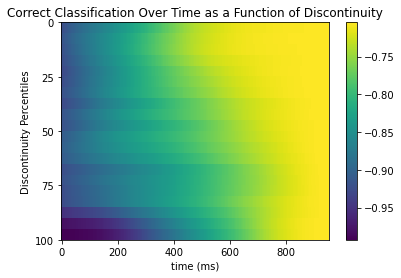

[18]
no


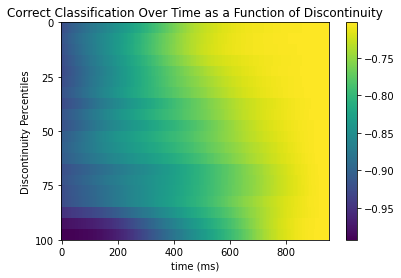

[34]
[34]
[18]
no


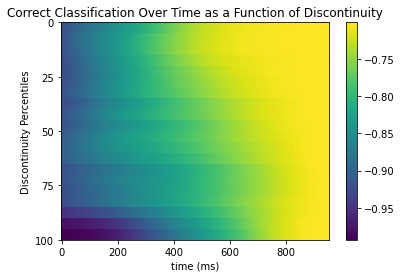

[34]
[18]
no


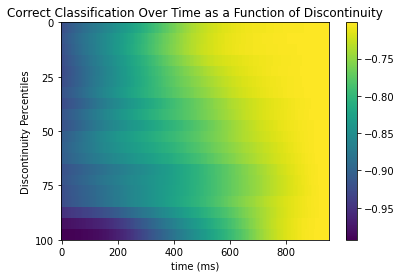

[18]
no


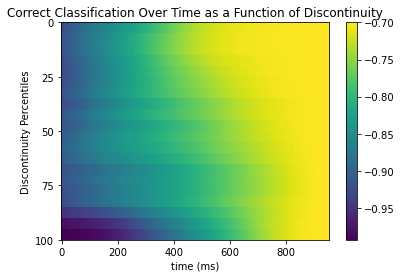

[34]
[34]
[18]
no


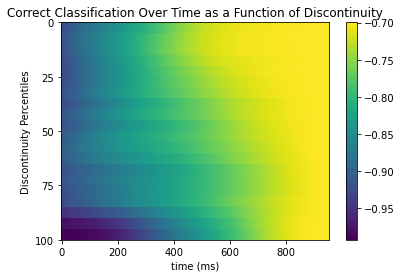

[34]
[18]
no


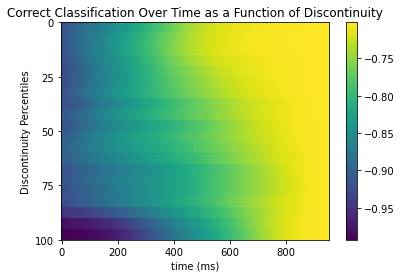

[34]
[18]
no


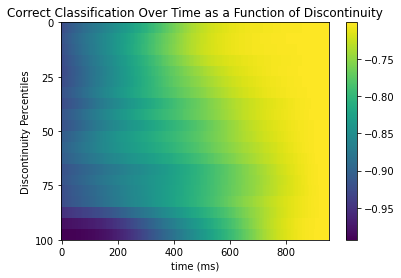

[34]
[18]
no


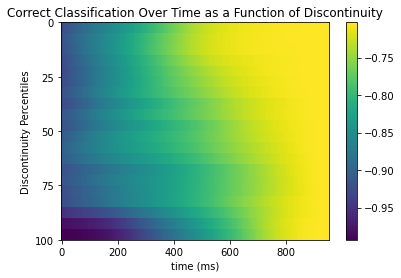

[18]
no


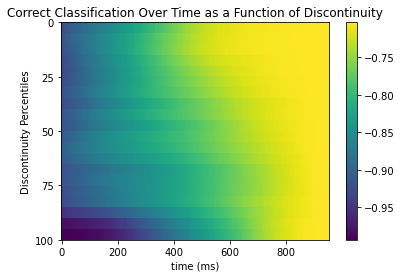

[34]
[34]
[34]
[34]
[18]
no


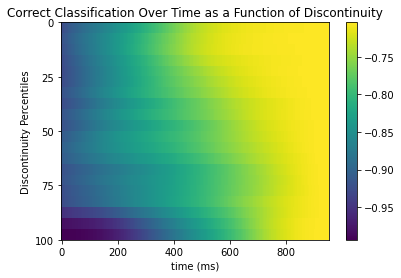

[18]
no


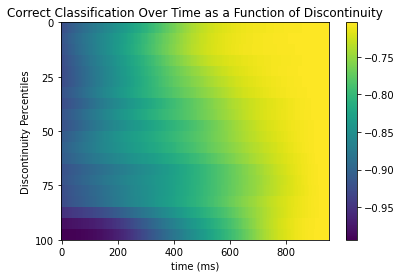

[18]
no


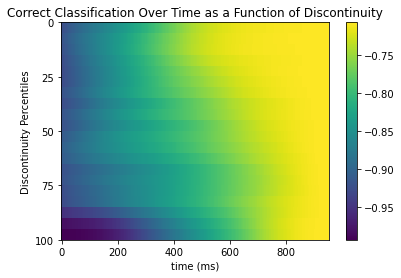

[18]
no


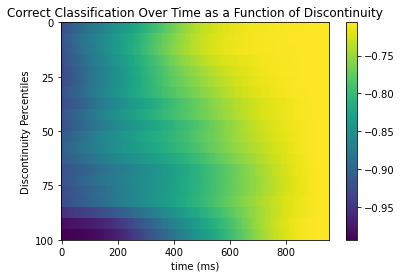

[18]
no


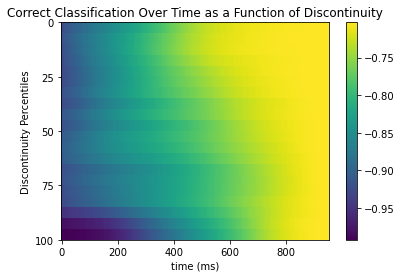

[18]
no


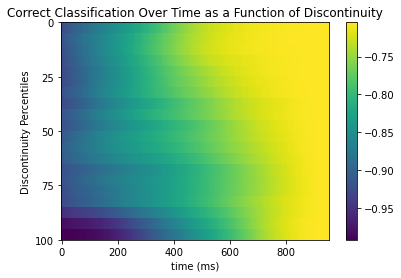

[34]
[34]
[34]
[34]
[18]
no


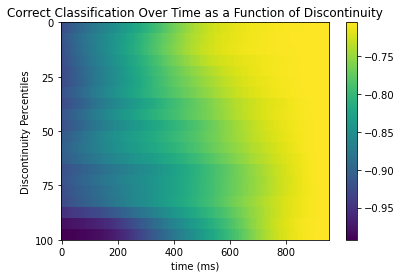

[34]
[34]
[34]
[18]
no


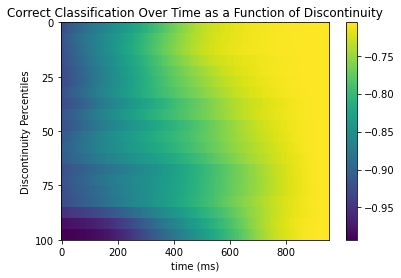

[18]
no


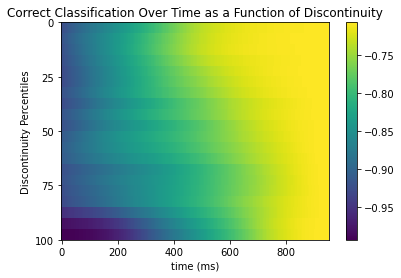

[34]
[18]
no


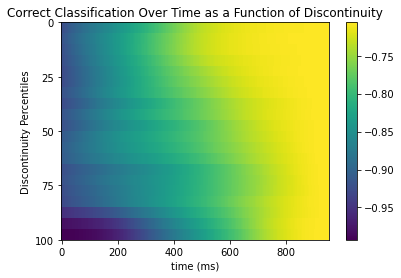

[34]
[18]
no


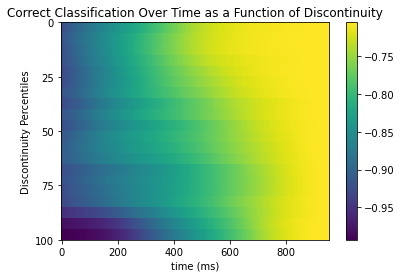

[34]
[34]
[34]
[34]
[34]
[18]
no


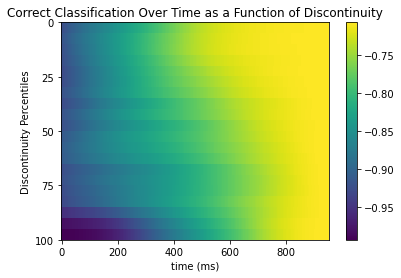

[34]
[18]
no


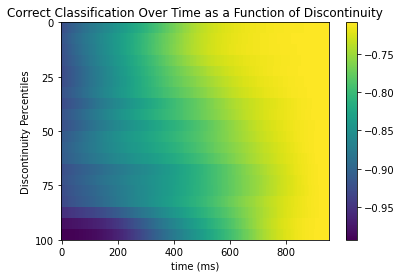

[34]
[34]
[18]
no


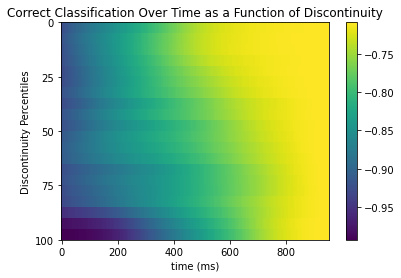

[34]
[18]
no


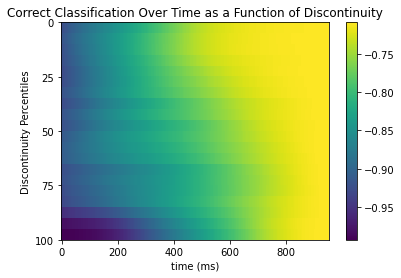

[18]
no


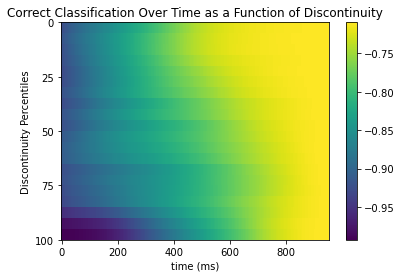

[34]
[18]
no


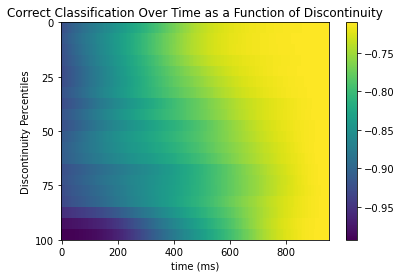

[18]
no


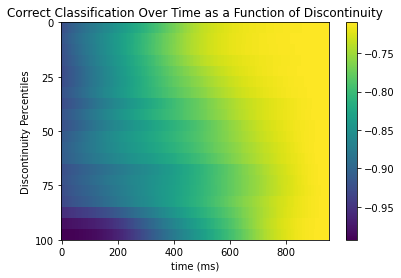

[34]
[34]
[34]
[34]
[34]
[34]
[18]
no


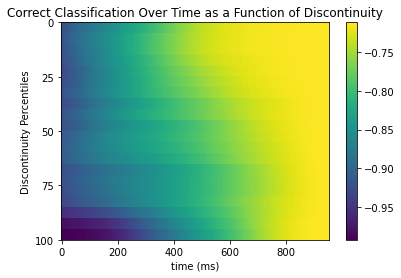

[34]
[34]
[34]
[34]
[34]
[18]
no


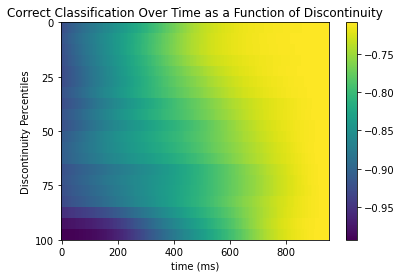

[34]
[34]
[34]
[18]
no


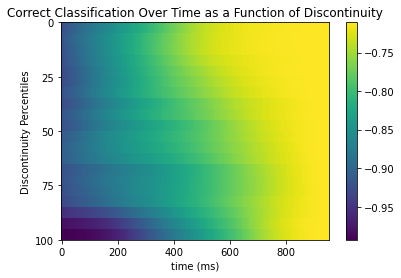

[18]
no


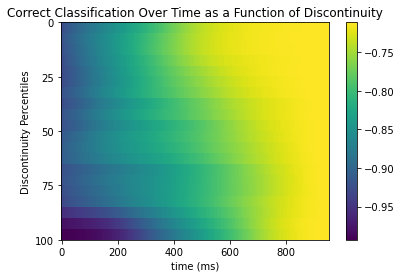

[34]
[34]
[18]
no


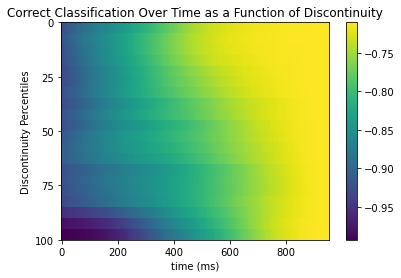

[34]
[34]
[18]
no


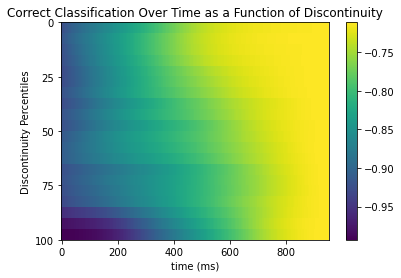

[34]
[18]
no


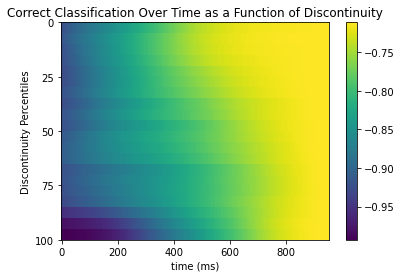

[34]
[34]
[18]
no


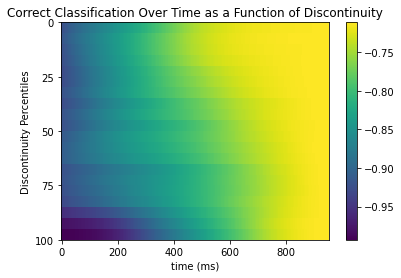

[34]
[34]
[18]
no


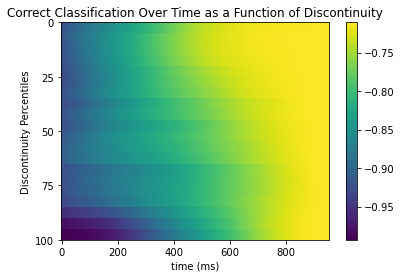

[18]
no


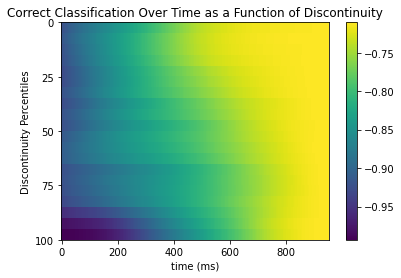

[18]
no


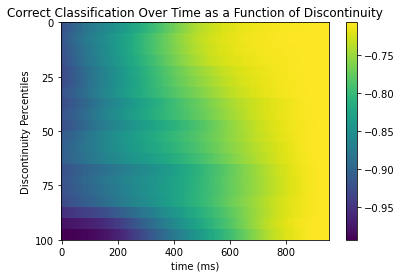

[34]
[34]
[18]
no


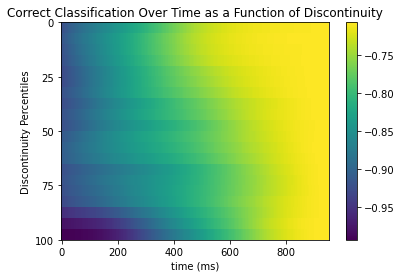

[18]
no


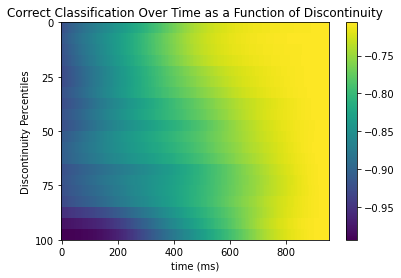

[34]
[18]
no


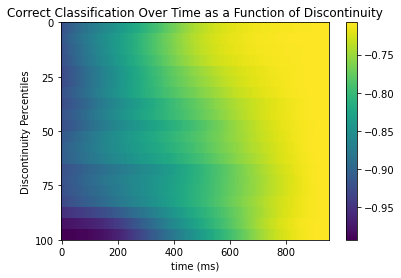

[18]
no


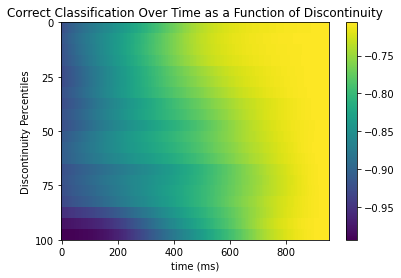

[34]
[18]
no


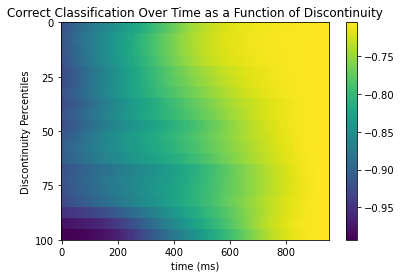

[34]
[34]
[34]
[18]
no


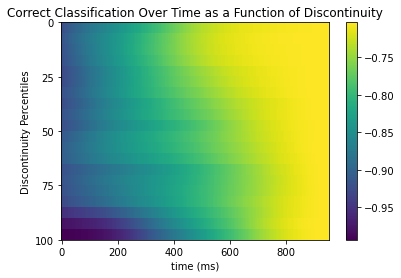

[34]
[18]
no


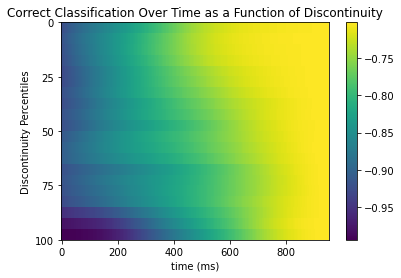

[34]
[18]
no


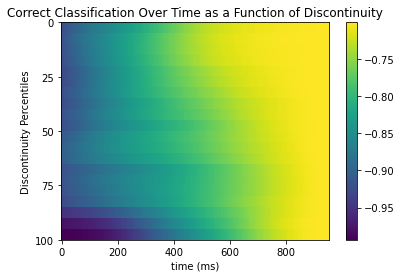

[18]
no


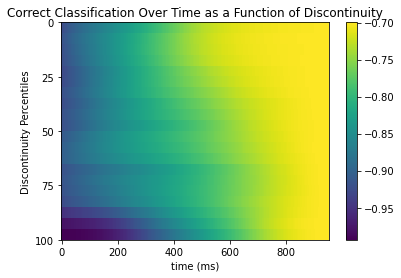

[18]
no


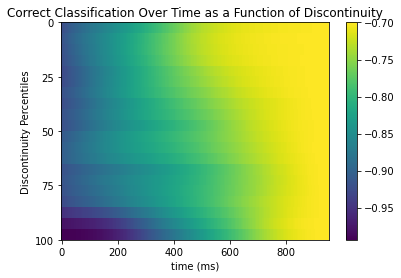

[34]
[18]
no


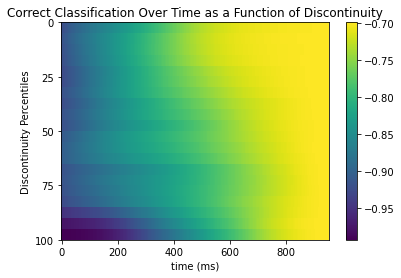

[18]
no


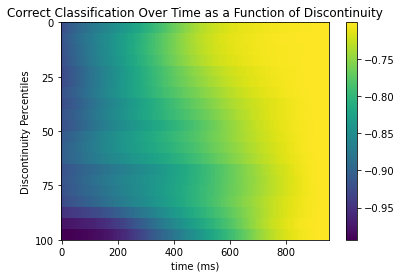

[18]
no


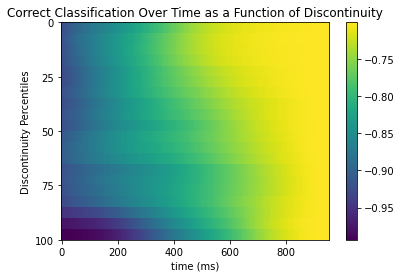

[18]
no


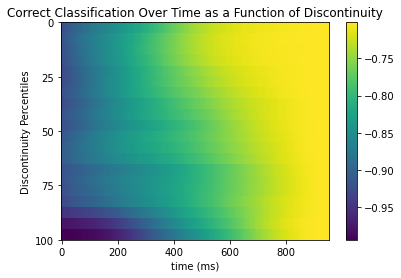

[34]
[18]
no


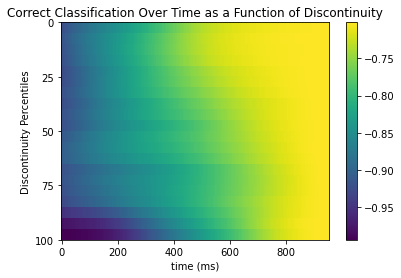

[34]
[18]
no


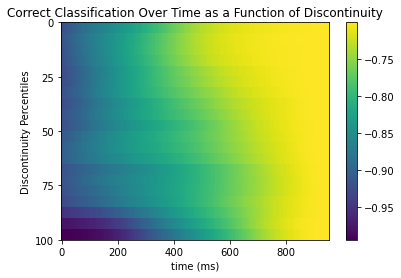

[34]
[34]
[18]
no


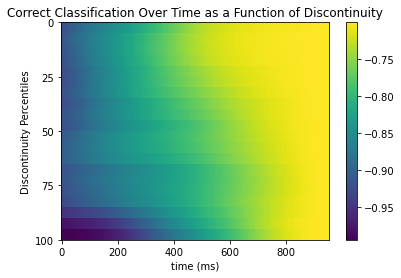

[18]
no


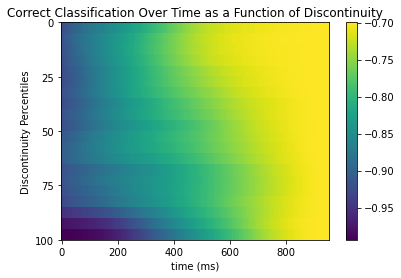

[18]
no


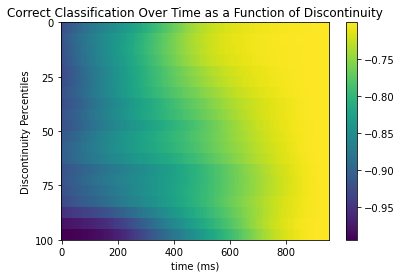

[34]
[34]
[18]
no


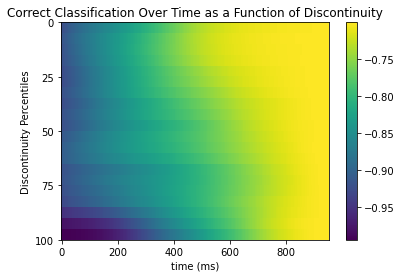

[18]
no


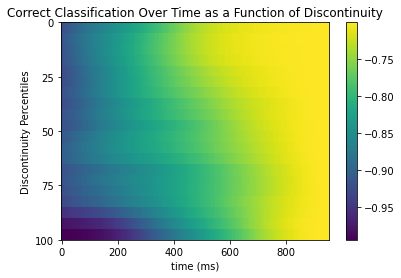

[18]
no


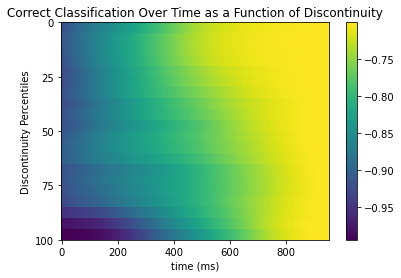

[18]
no


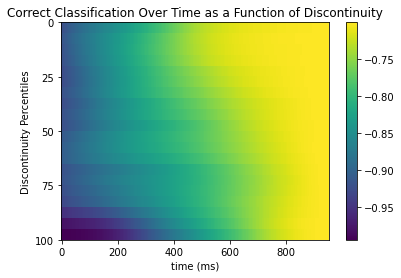

[18]
no


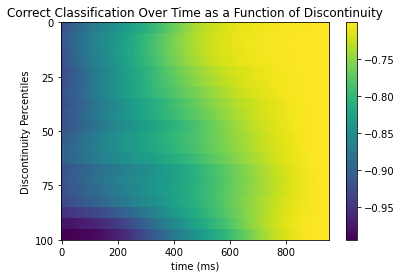

[18]
no


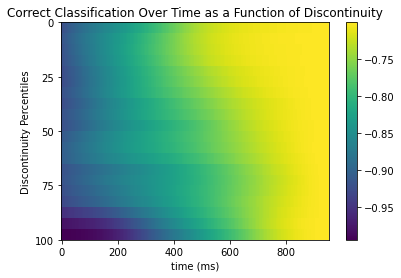

[18]
no


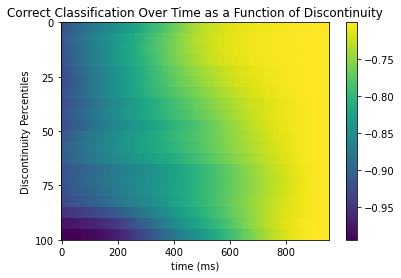

[34]
[18]
no


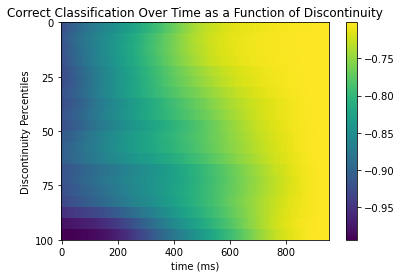

[18]
no


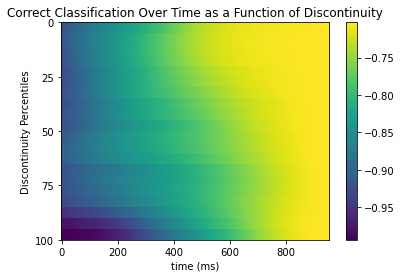

[18]
no


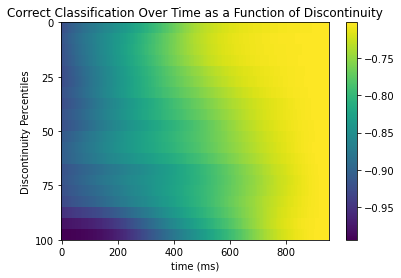

[34]
[18]
no


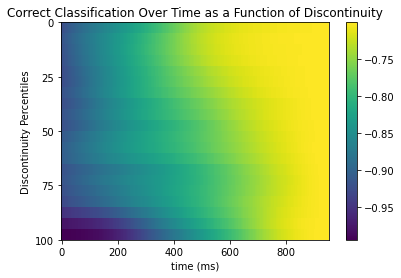

[34]
[18]
no


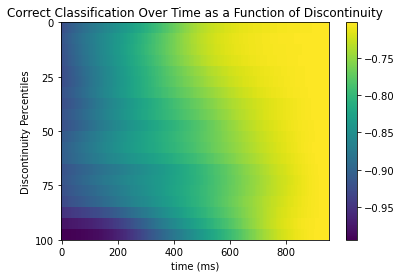

[34]
[18]
no


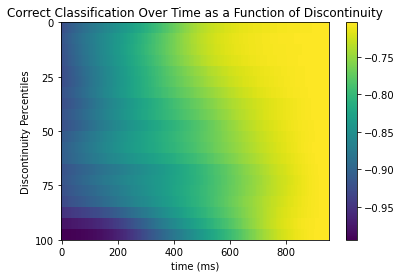

[18]
no


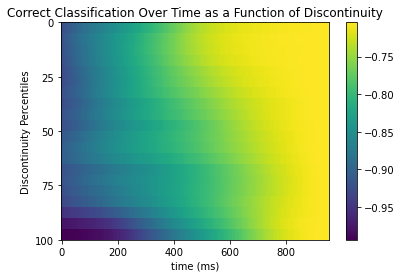

[18]
no


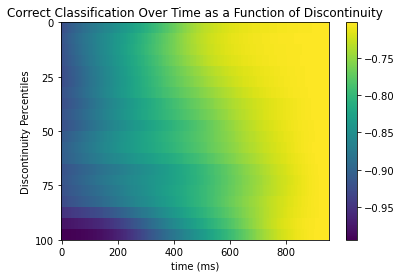

[18]
no


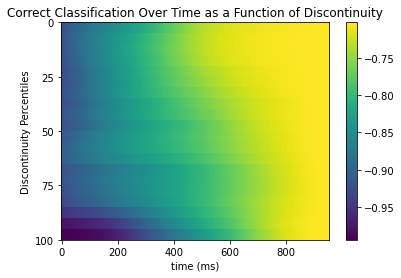

[34]
[18]
no


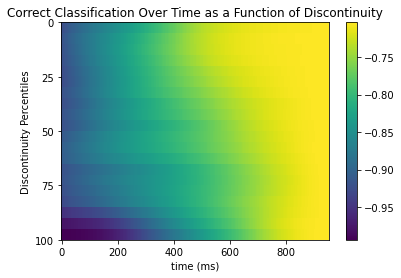

[34]
[34]
[34]
[34]
[18]
no


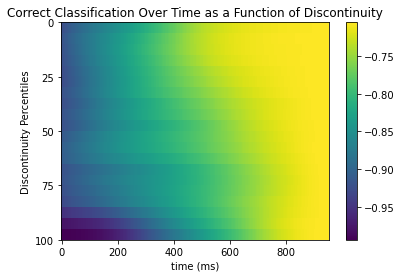

[18]
no


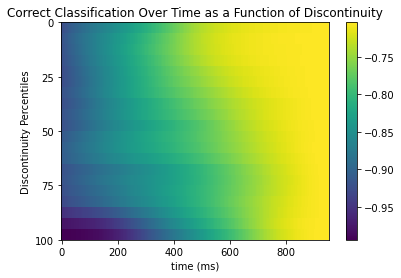

[18]
no


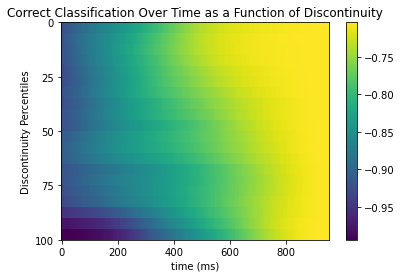

[34]
[34]
[18]
no


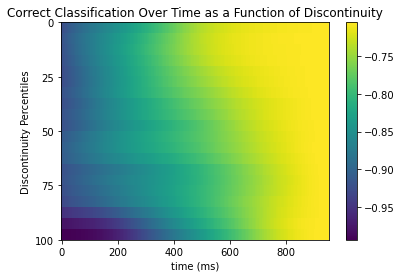

[34]
[18]
no


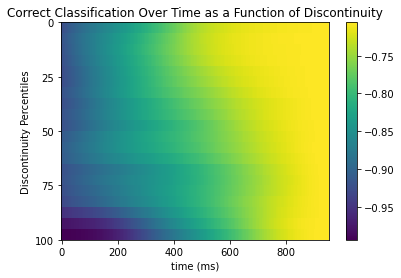

[18]
no


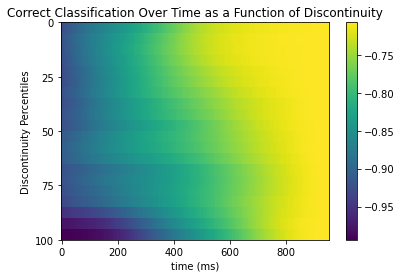

[34]
[18]
no


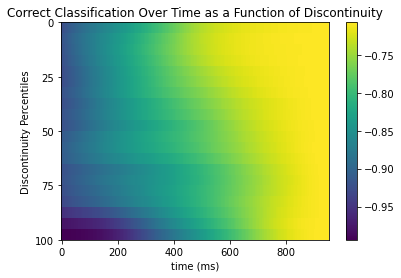

[18]
no


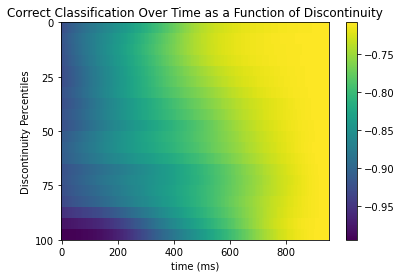

[34]
[34]
[34]
[18]
no


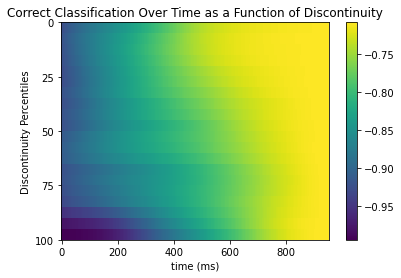

[18]
no


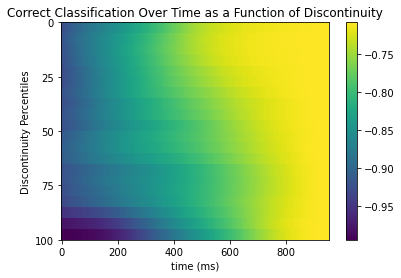

[34]
[18]
no


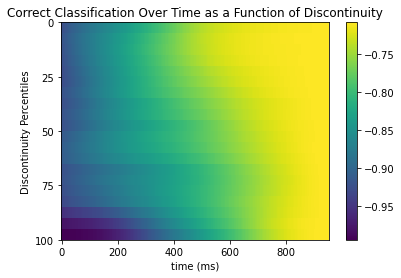

[18]
no


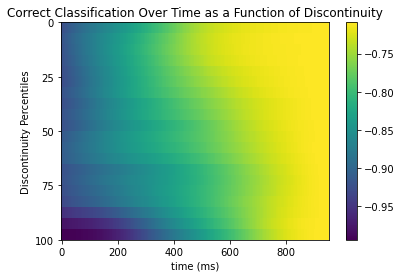

[18]
no


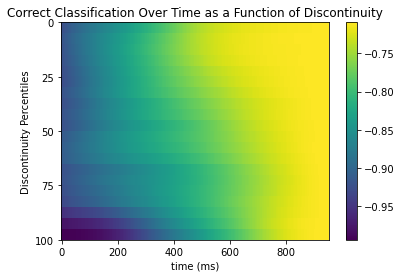

[18]
no


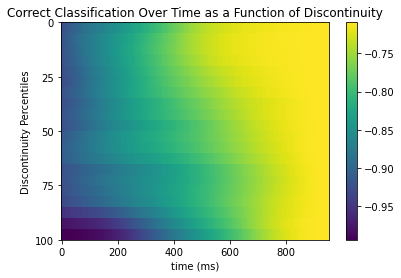

[18]
no


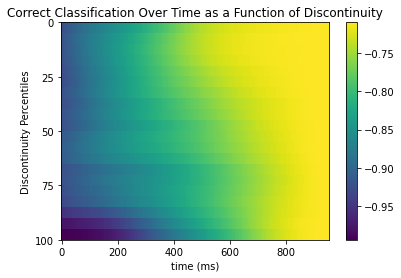

[18]
no


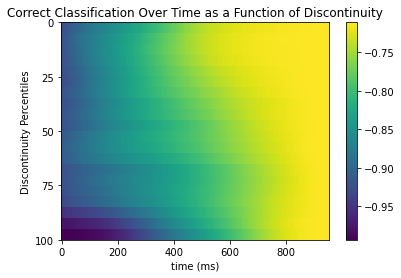

[18]
no


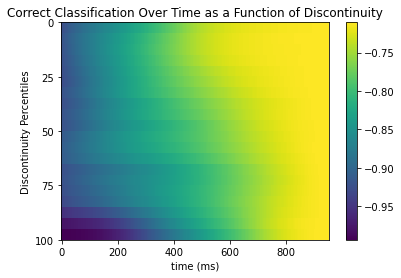

[18]
no


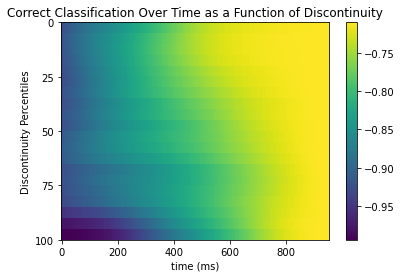

[18]
no


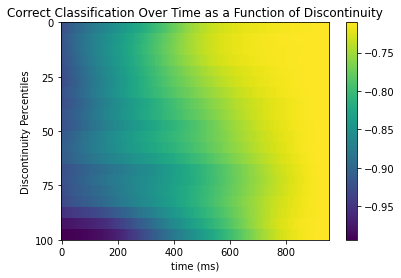

[34]
[18]
no


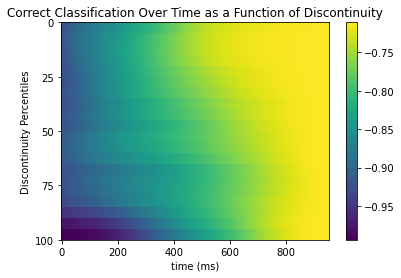

[34]
[18]
no


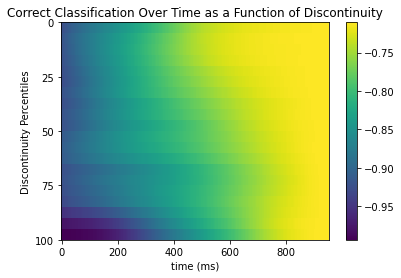

[18]
no


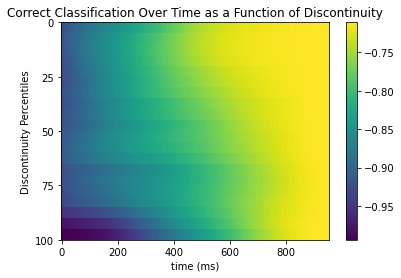

[34]
[18]
no


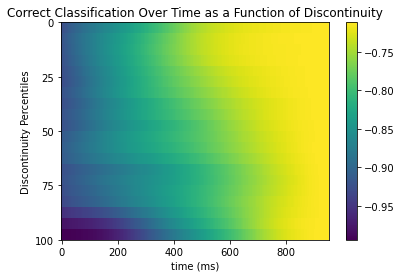

[34]
[18]
no


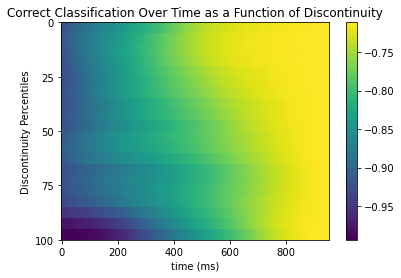

[18]
no


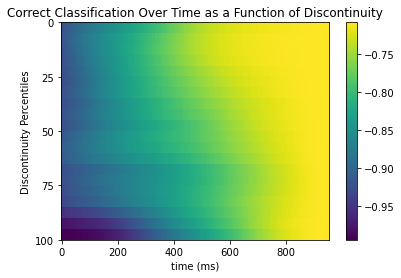

[18]
no


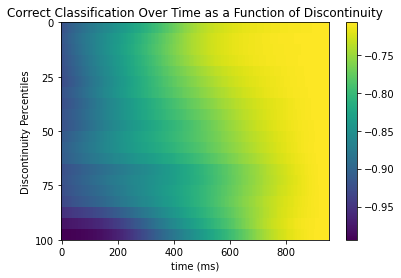

[34]
[34]
[18]
no


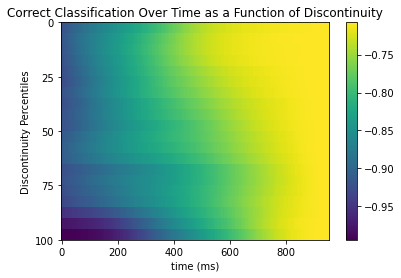

[18]
no


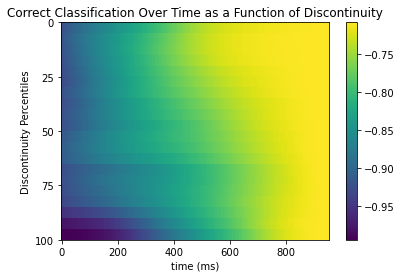

[34]
[18]
no


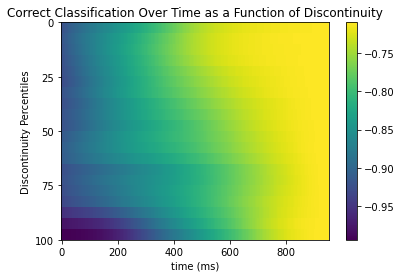

[34]
[18]
no


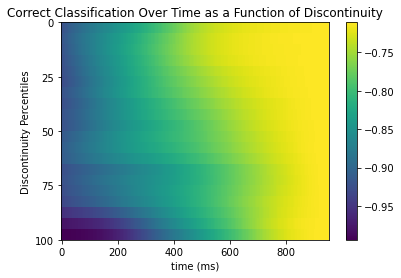

[34]
[34]
[18]
no


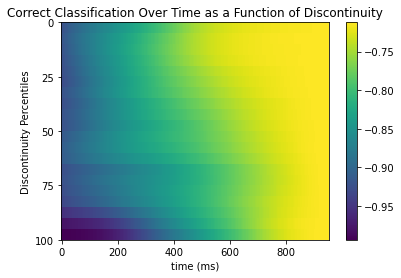

[18]
no


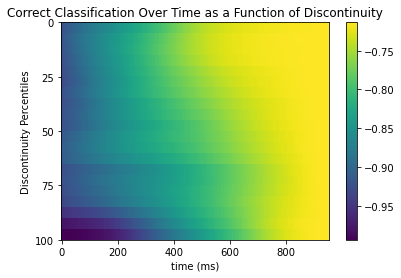

[34]
[18]
no


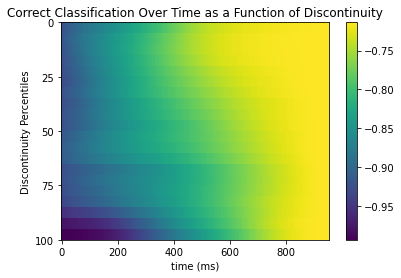

[34]
[18]
no


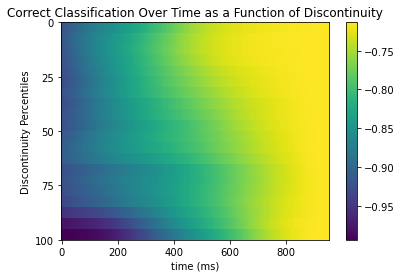

[18]
no


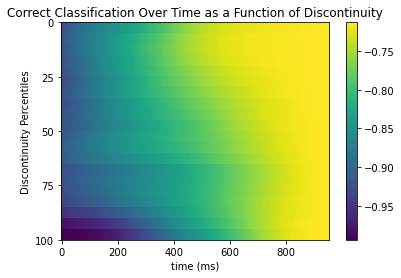

[18]
no


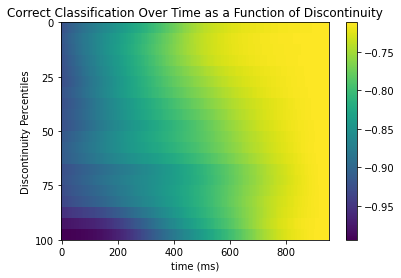

[34]
[34]
[34]
[18]
no


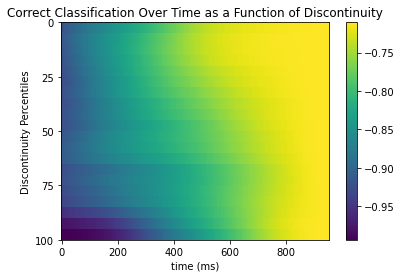

[34]
[18]
no


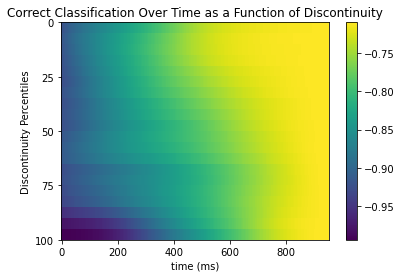

[34]
[18]
no


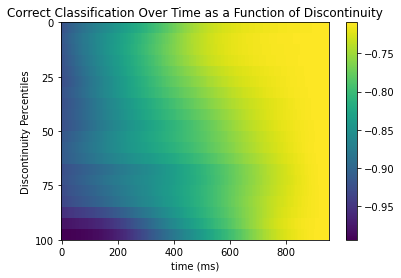

[34]
[18]
no


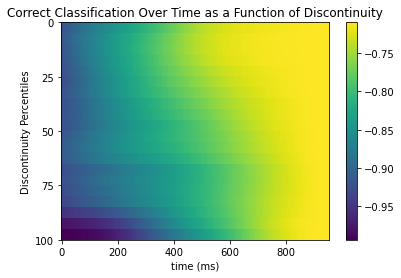

[18]
no


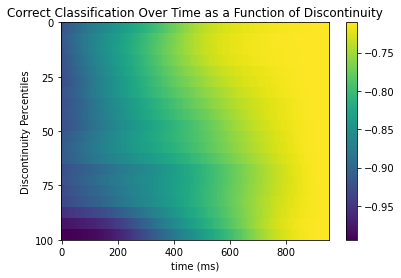

[34]
[18]
no


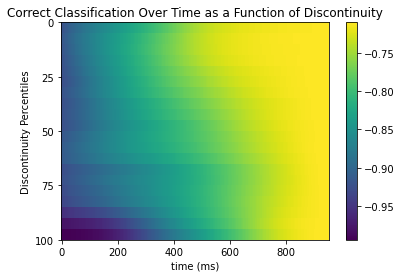

[34]
[18]
no


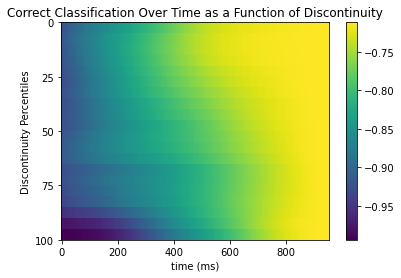

[18]
no


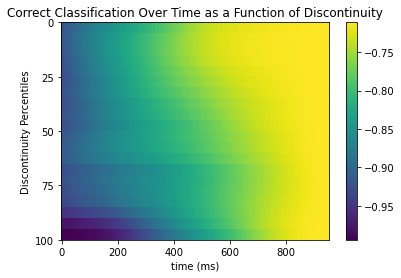

[18]
no


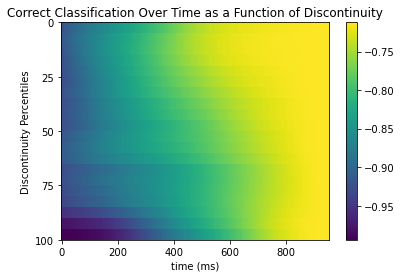

[18]
no


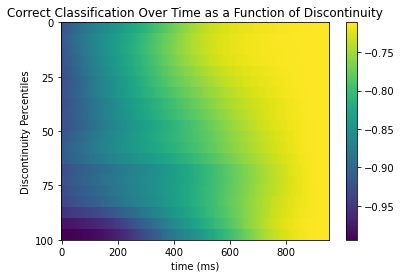

[18]
no


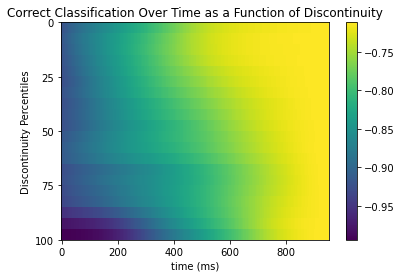

[18]
no


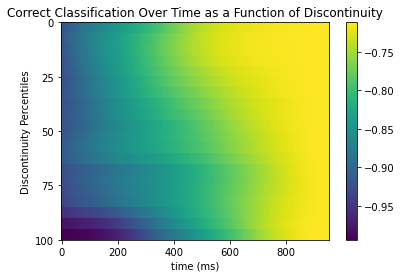

[34]
[18]
no


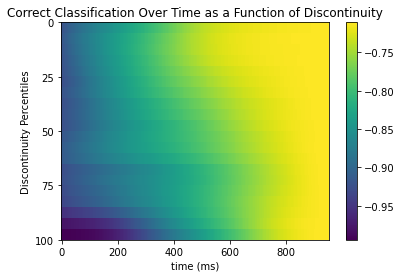

[18]
no


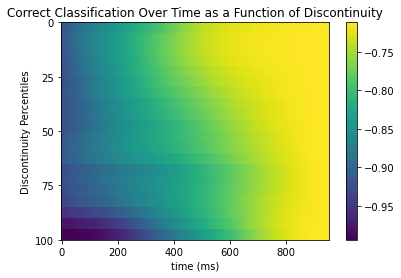

[34]
[34]
[18]
no


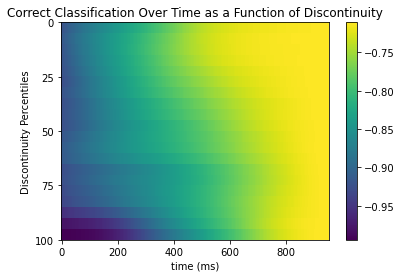

[18]
no


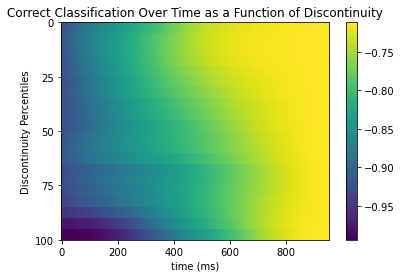

[34]
[18]
no


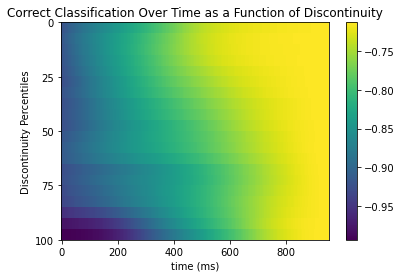

[34]
[34]
[34]
[34]
[18]
no


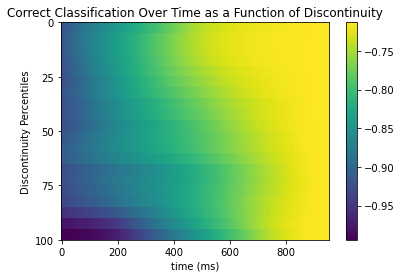

[18]
no


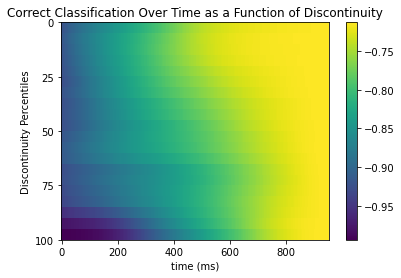

[18]
no


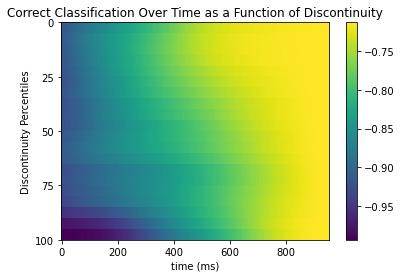

[34]
[18]
no


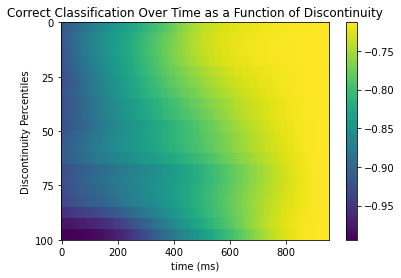

[34]
[34]
[34]
[34]
[34]
[18]
no


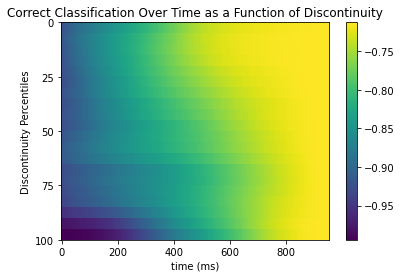

[18]
no


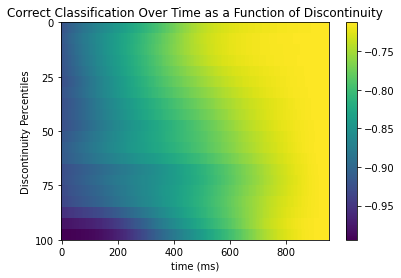

[34]
[18]
no


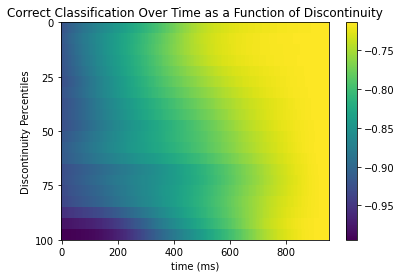

[18]
no


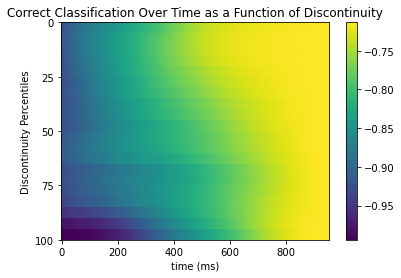

[18]
no


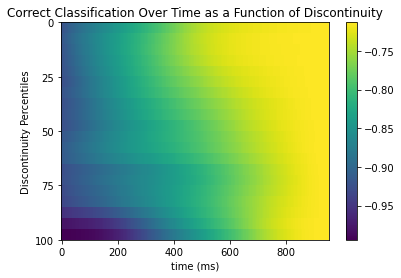

[18]
no


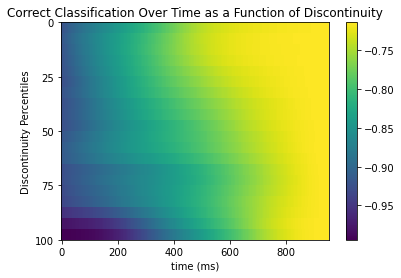

[18]
no


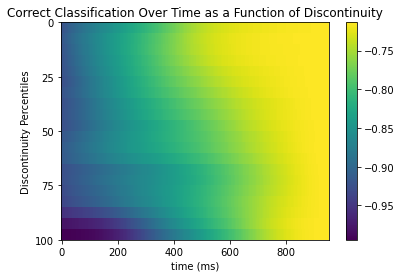

[18]
no


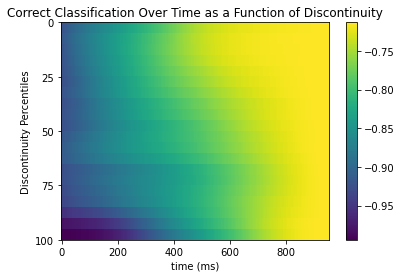

[18]
no


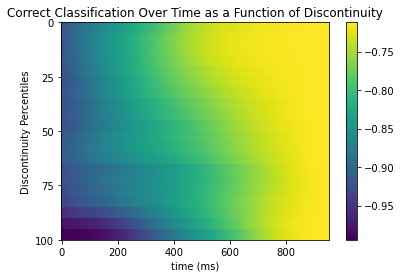

[18]
no


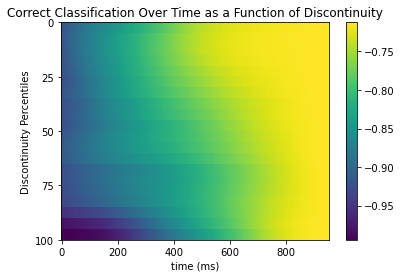

[34]
[18]
no


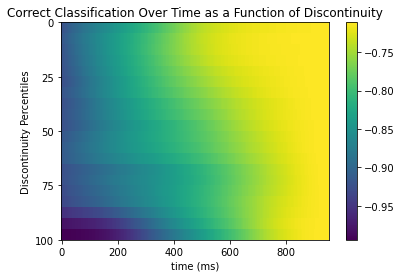

[18]
no


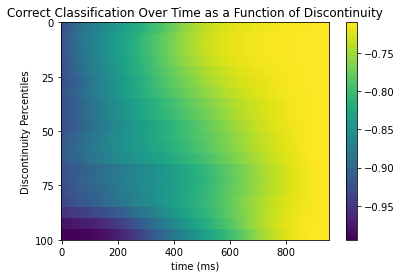

[34]
[18]
no


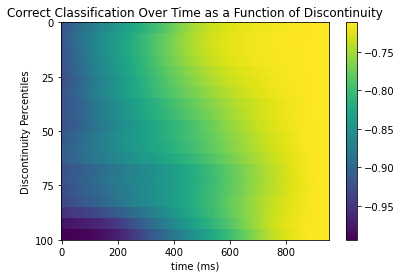

[18]
no


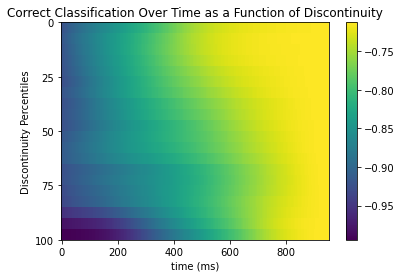

[34]
[34]
[34]
[18]
no


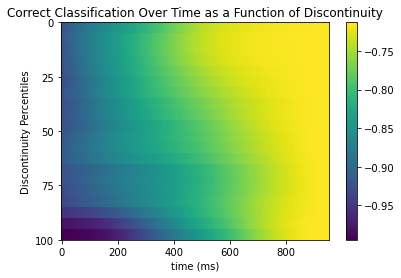

[34]
[18]
no


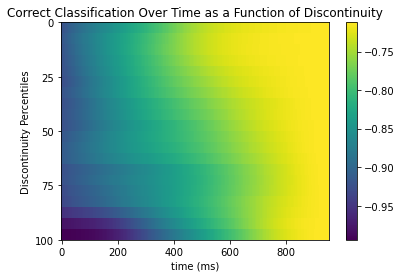

[34]
[18]
no


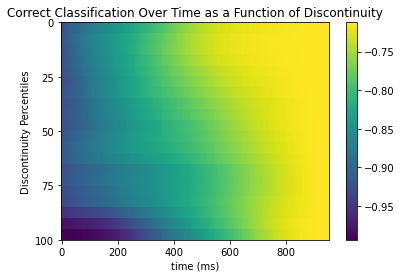

[18]
no


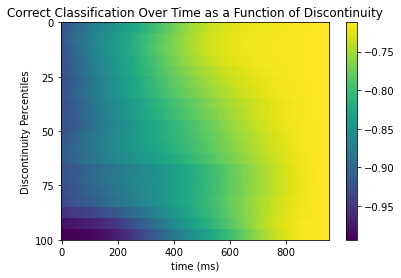

[18]
no


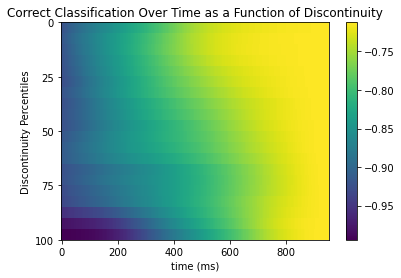

[34]
[34]
[34]
[18]
no


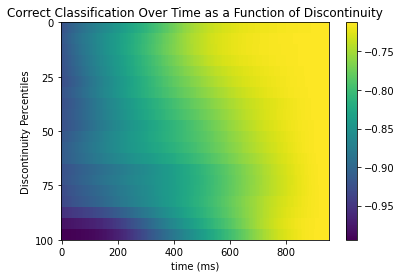

[34]
[34]
[18]
no


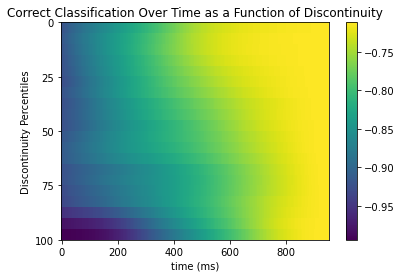

[34]
[34]
[34]
[18]
no


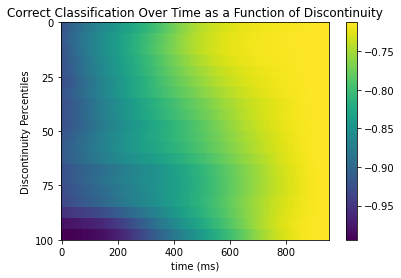

[34]
[34]
[18]
no


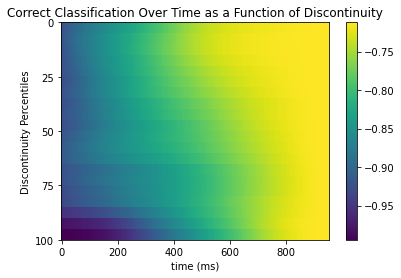

[34]
[34]
[18]
no


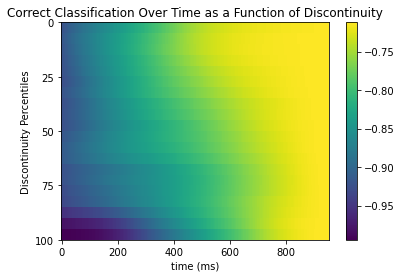

[18]
no


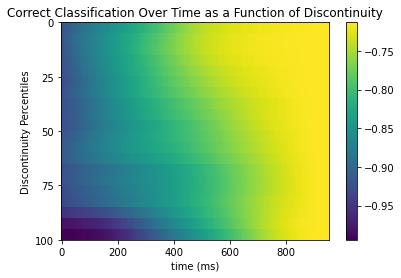

[34]
[34]
[34]
[18]
no


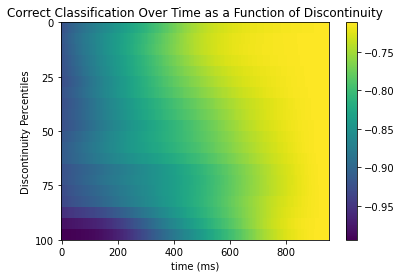

[18]
no


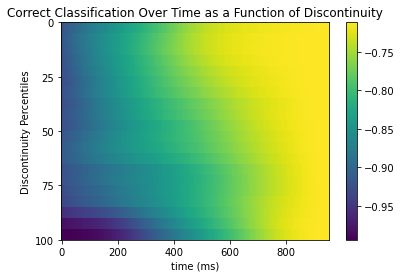

[18]
no


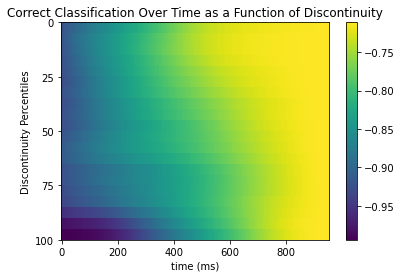

[34]
[34]
[34]
[34]
[18]
no


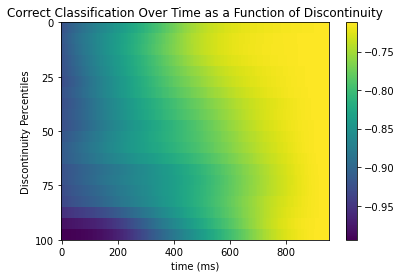

[34]
[18]
no


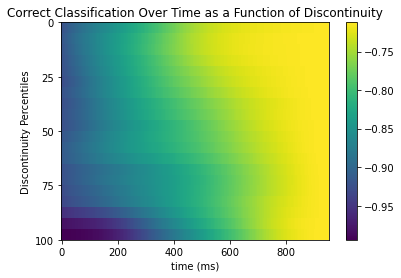

[34]
[34]
[18]
no


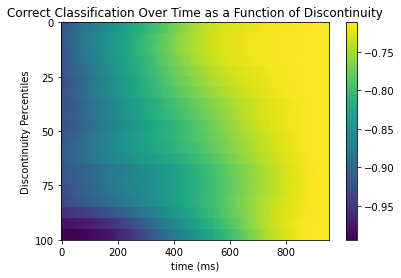

[18]
no


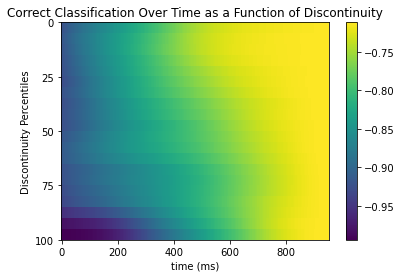

[18]
no


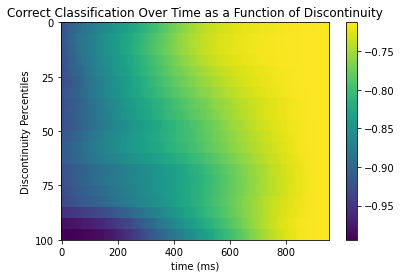

[34]
[34]
[34]
[34]
[18]
no


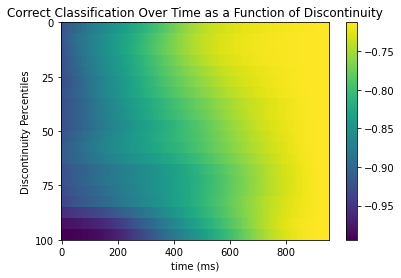

[18]
no


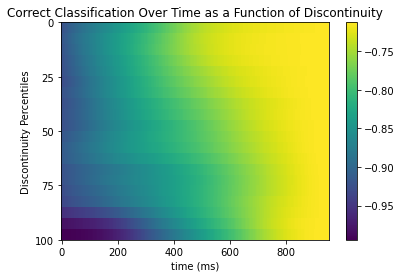

[34]
[34]
[18]
no


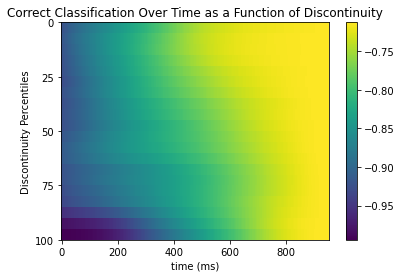

[34]
[18]
no


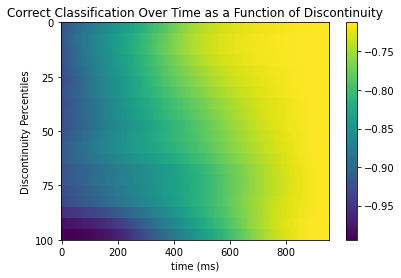

[18]
no


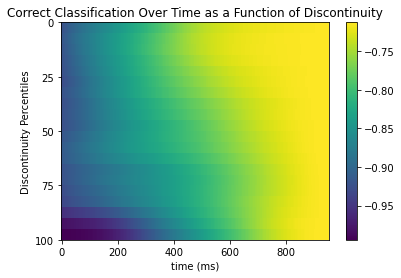

[34]
[18]
no


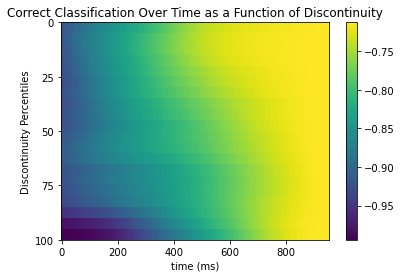

[18]
no


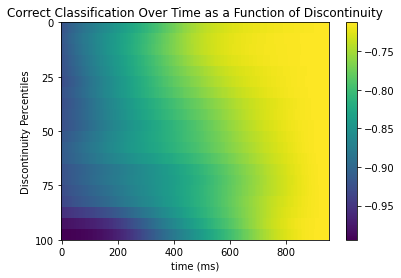

[34]
[34]
[18]
no


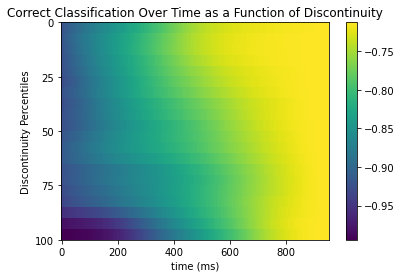

[34]
[18]
no


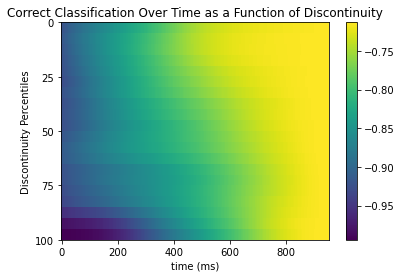

[18]
no


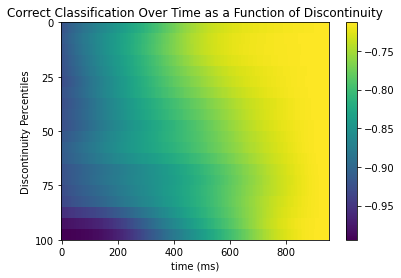

[34]
[18]
no


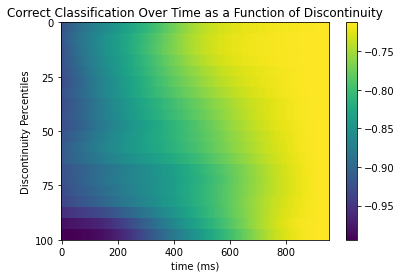

[18]
no


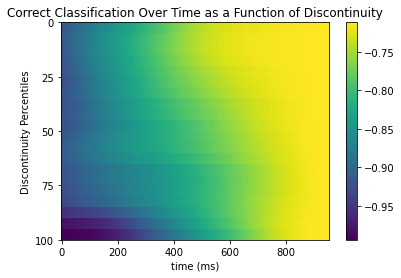

[18]
no


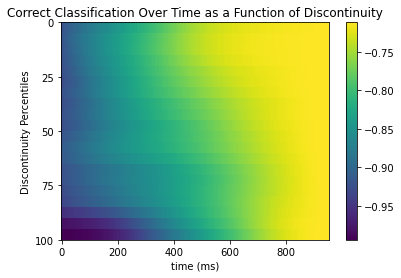

[18]
no


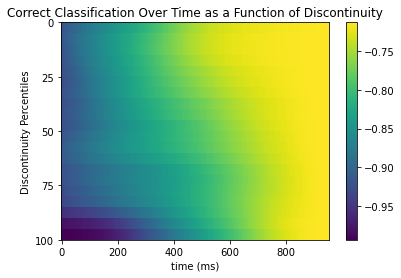

[18]
no


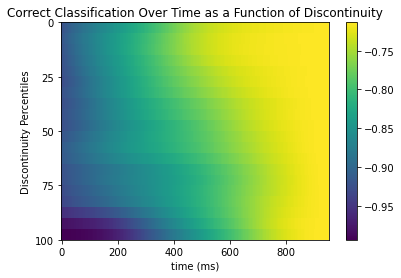

[34]
[18]
no


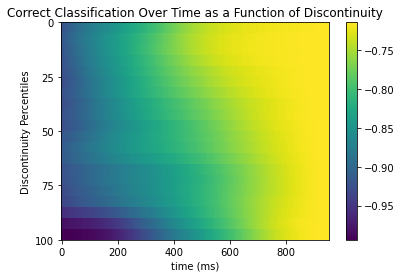

[34]
[18]
no


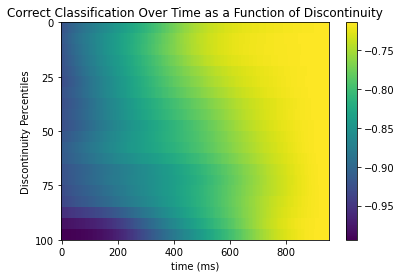

[34]
[34]
[18]
no


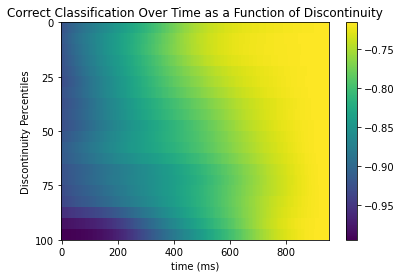

[34]
[18]
no


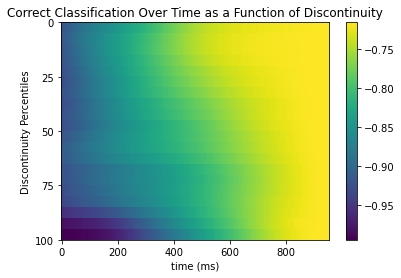

[34]
[34]
[34]
[18]
no


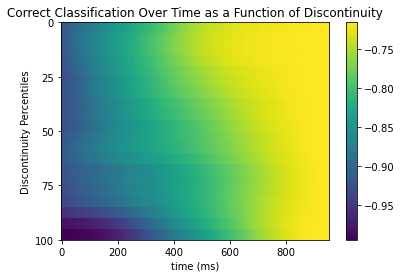

[18]
no


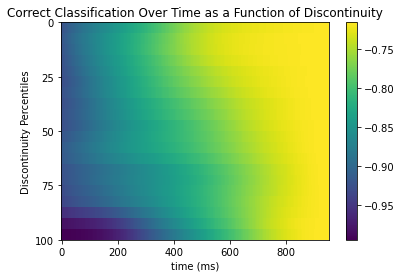

[34]
[34]
[18]
no


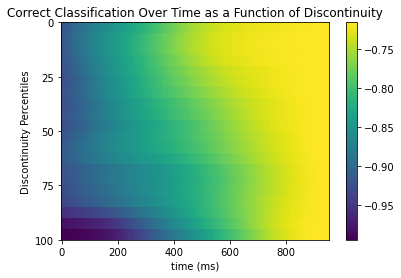

[34]
[34]
[34]
[34]
[34]
[18]
no


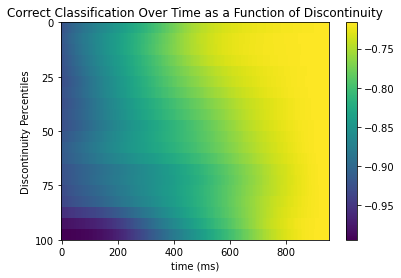

[34]
[18]
no


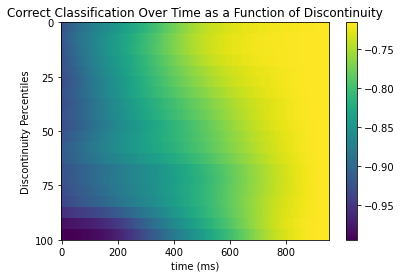

[34]
[34]
[18]
no


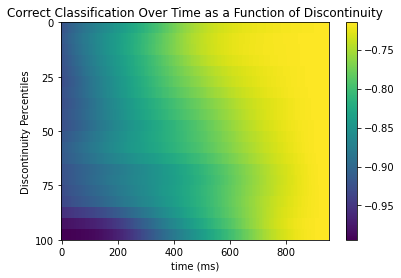

[18]
no


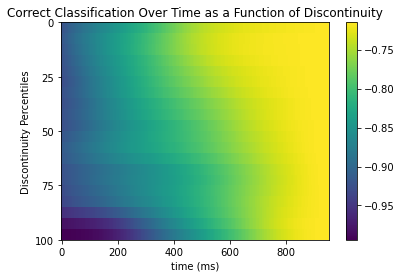

[34]
[34]
[18]
no


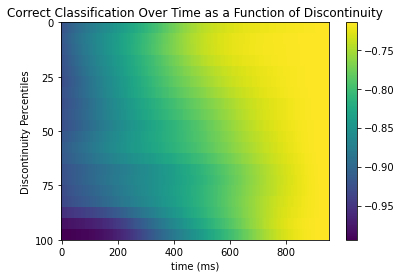

[34]
[34]
[34]
[34]
[34]
[34]
[34]
[18]
no


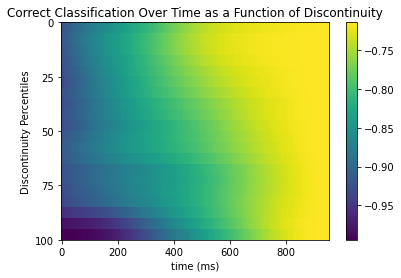

[18]
no


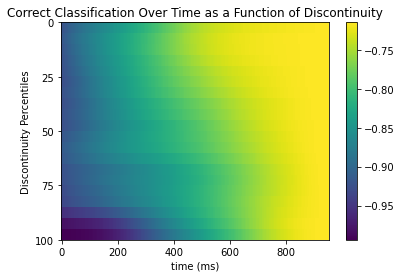

[18]
no


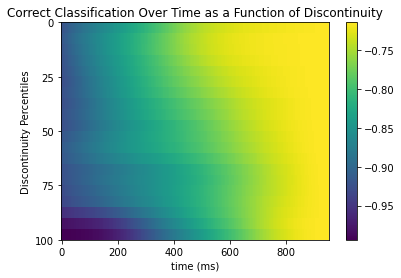

[34]
[34]
[34]
[34]
[34]
[18]
no


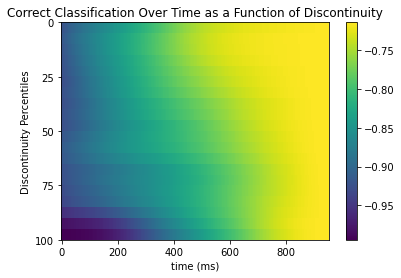

[34]
[34]
[34]
[18]
no


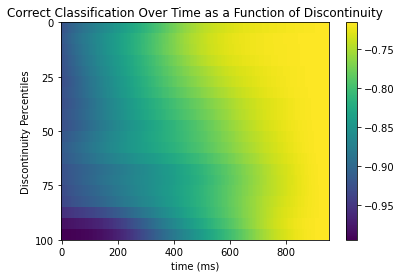

[18]
no


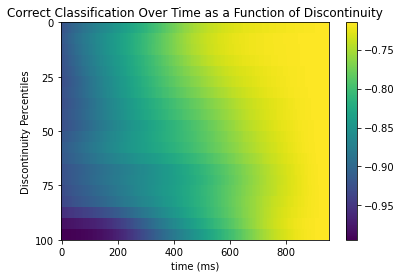

[18]
no


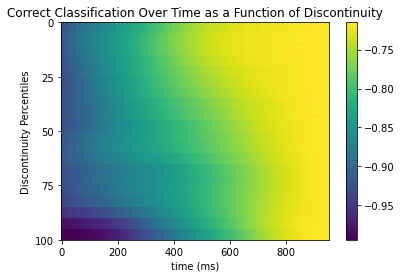

[34]
[34]
[34]
[34]
[34]
[18]
no


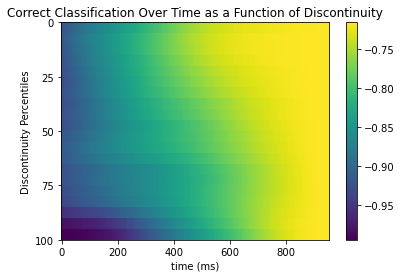

[18]
no


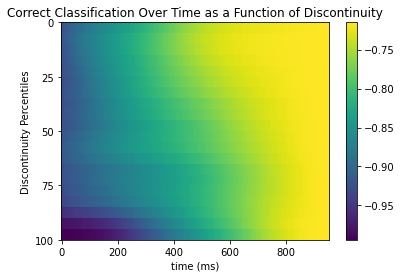

[34]
[34]
[18]
no


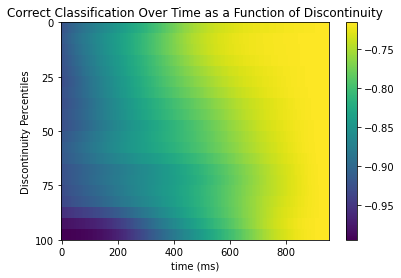

[18]
no


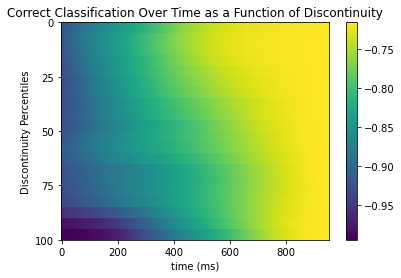

[18]
no


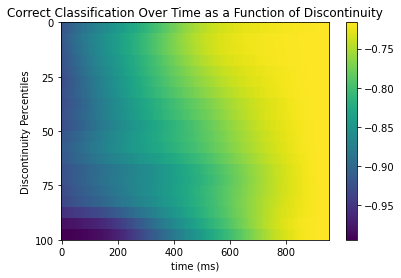

[34]
[18]
no


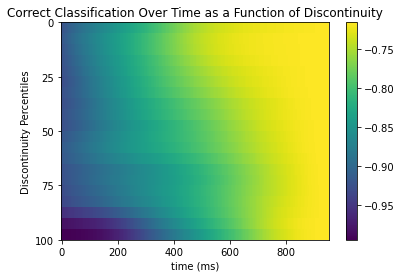

[18]
no


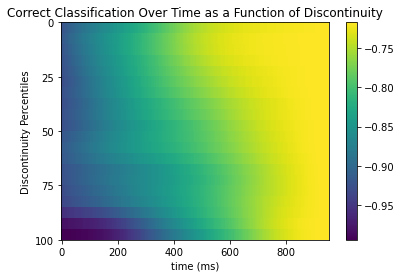

[18]
no


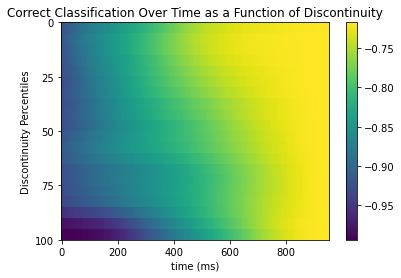

[18]
no


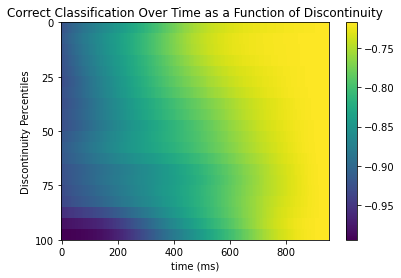

[18]
no


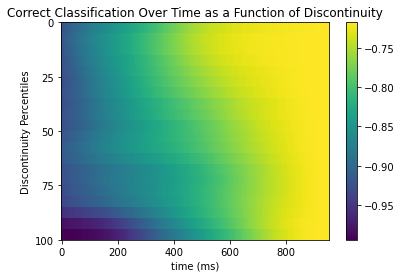

[34]
[18]
no


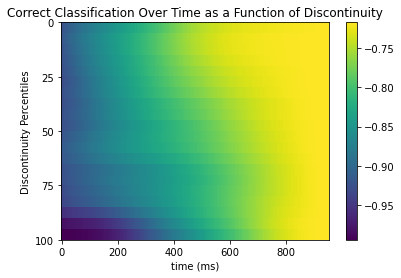

[34]
[34]
[18]
no


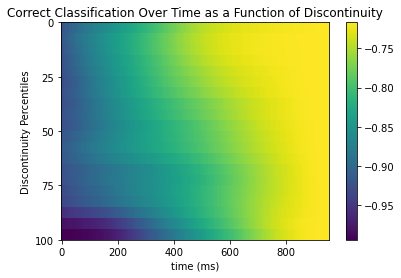

[18]
no


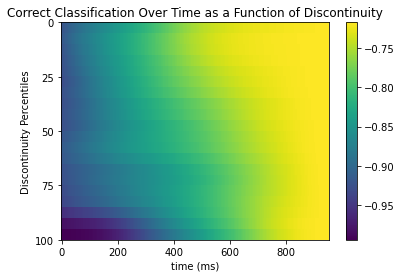

[34]
[34]
[34]
[34]
[34]
[34]
[34]
[18]
no


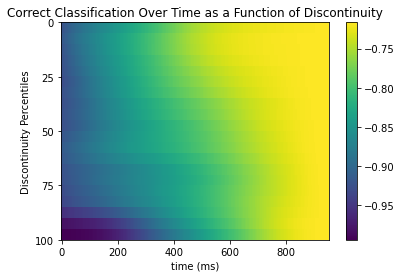

[18]
no


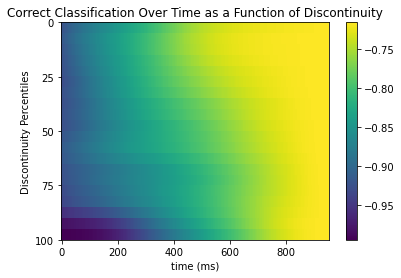

[18]
no


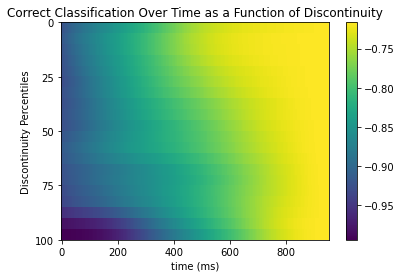

[34]
[34]
[34]
[34]
[18]
no


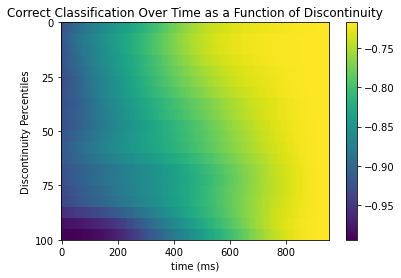

[18]
no


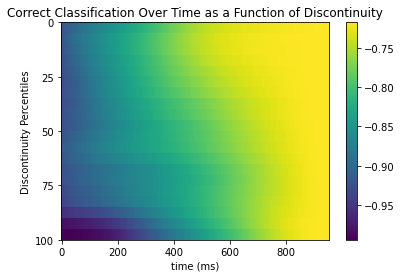

[18]
no


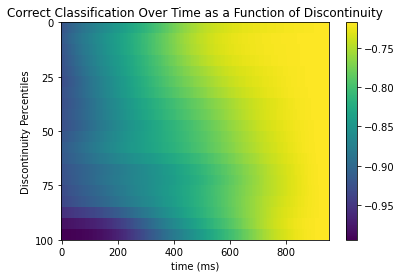

[18]
no


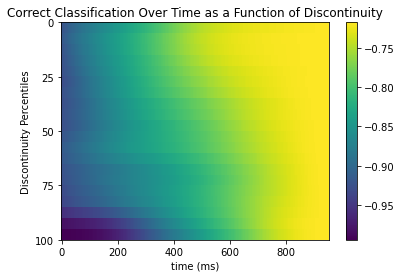

[34]
[18]
no


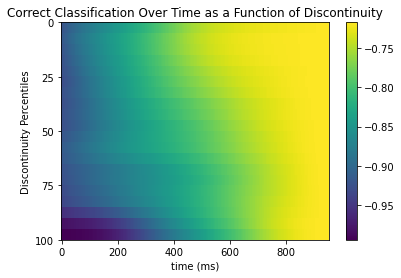

[18]
no


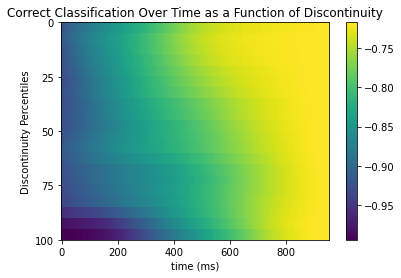

[18]
no


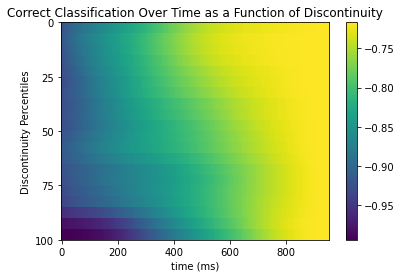

[34]
[34]
[18]
no


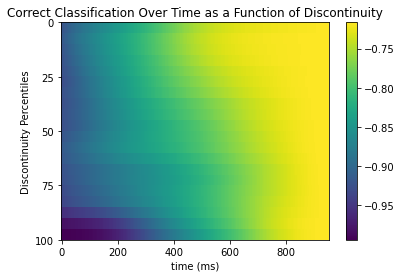

[34]
[18]
no


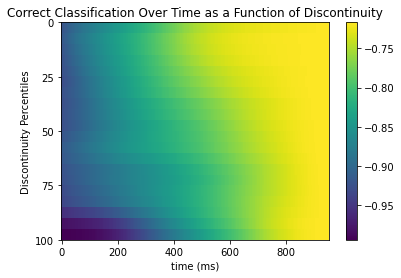

[18]
no


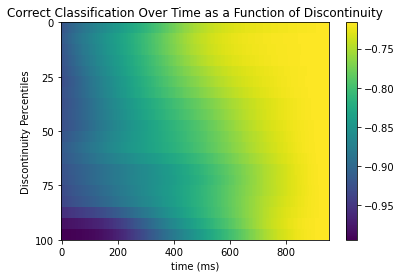

[18]
no


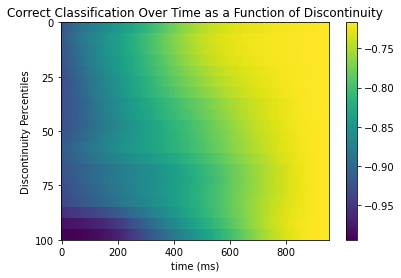

[34]
[34]
[18]
no


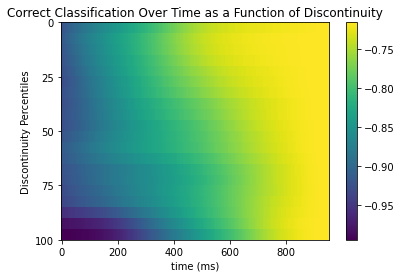

[18]
no


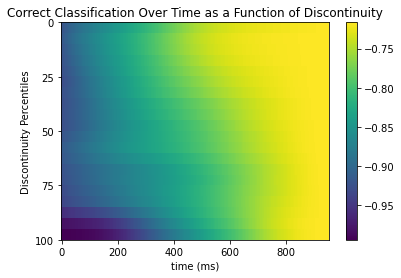

[34]
[18]
no


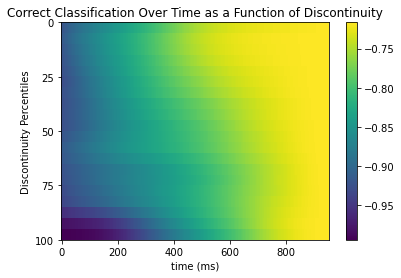

[18]
no


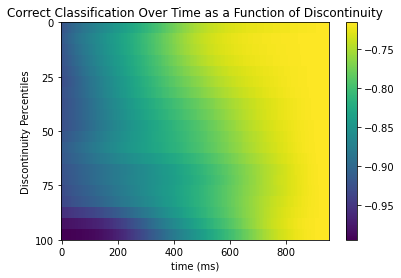

[34]
[18]
no


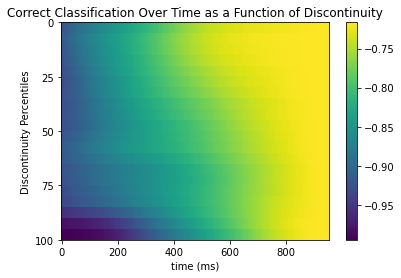

[18]
no


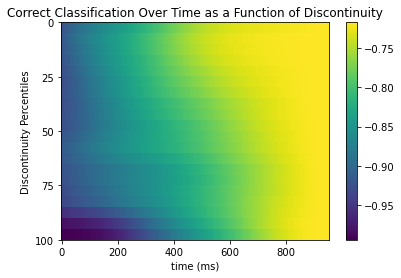

[18]
no


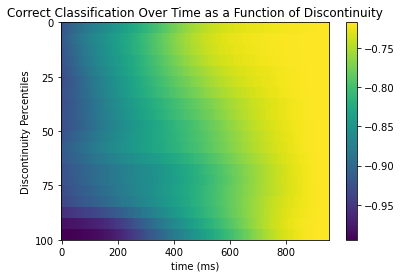

[34]
[34]
[34]
[18]
no


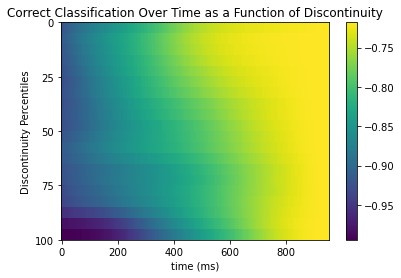

[18]
no


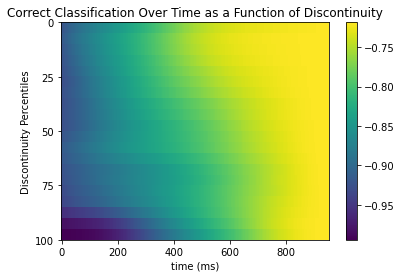

[34]
[34]
[18]
no


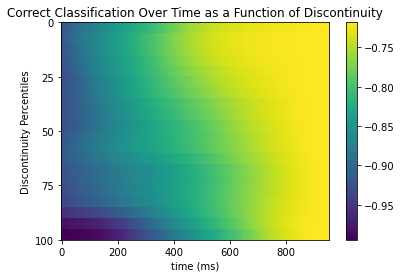

[34]
[18]
no


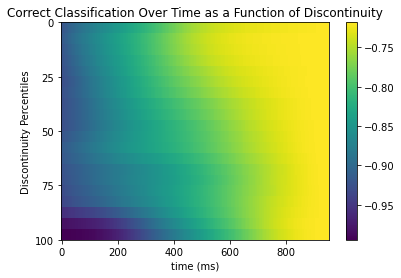

[18]
no


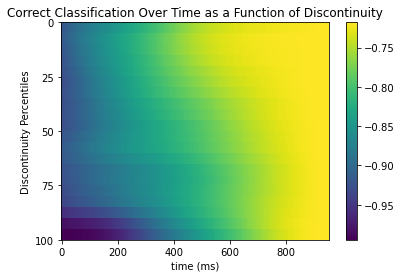

[18]
no


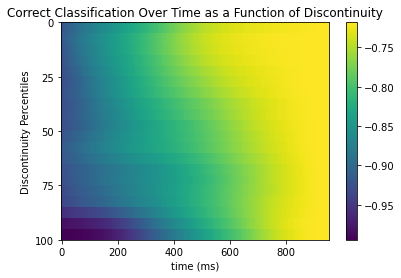

[34]
[18]
no


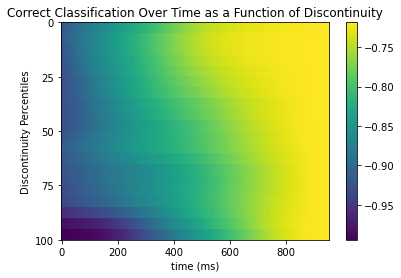

[34]
[18]
no


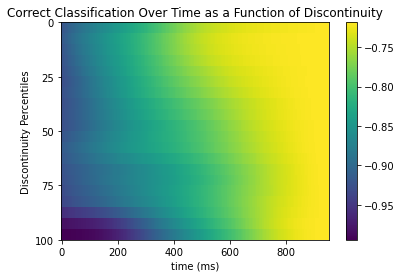

[34]
[18]
no


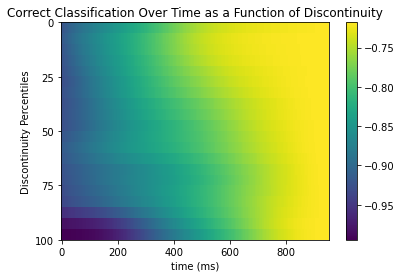

[18]
no


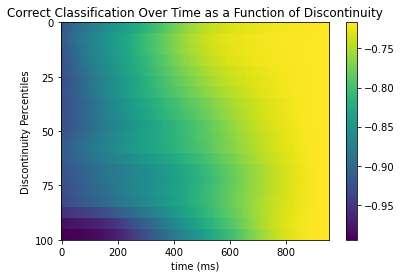

[18]
no


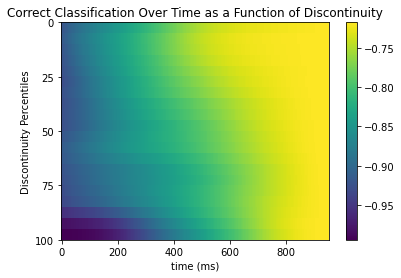

[34]
[18]
no


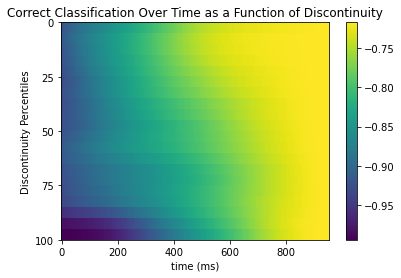

[34]
[18]
no


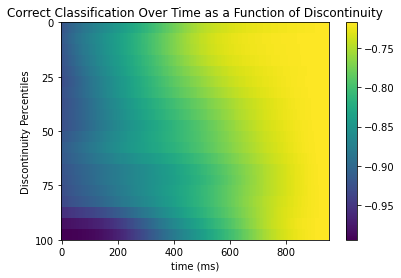

[18]
no


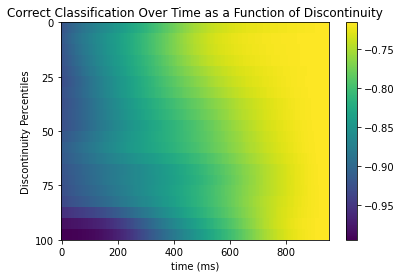

[34]
[34]
[34]
[34]
[34]
[34]
[34]
[18]
no


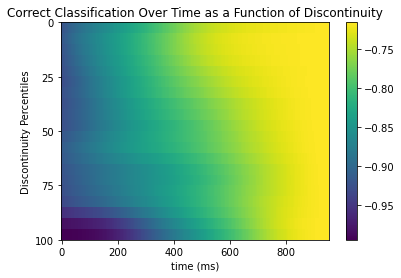

[34]
[18]
no


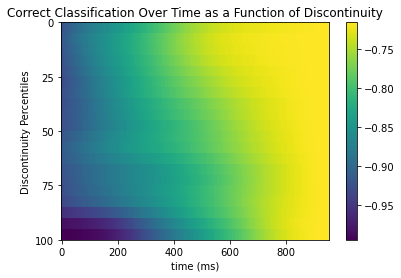

[18]
no


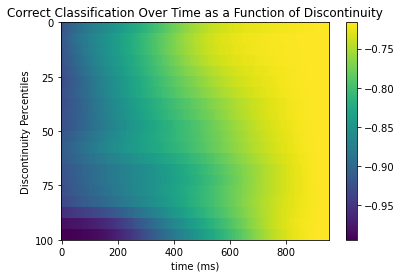

[18]
no


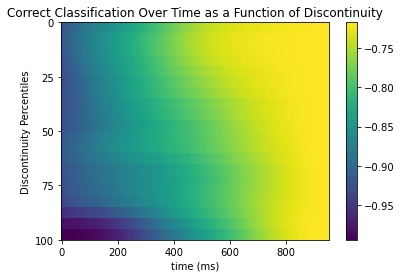

[18]
no


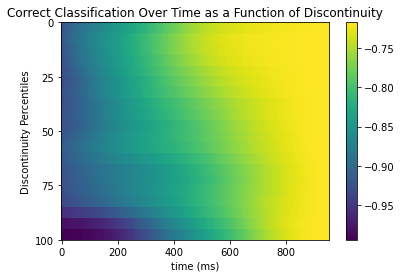

[18]
no


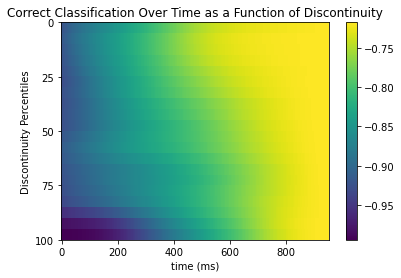

[18]
no


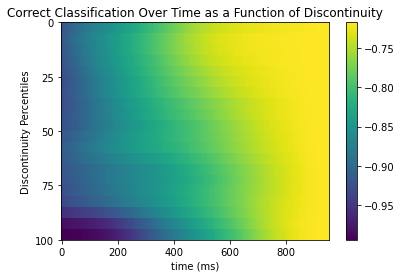

[18]
no


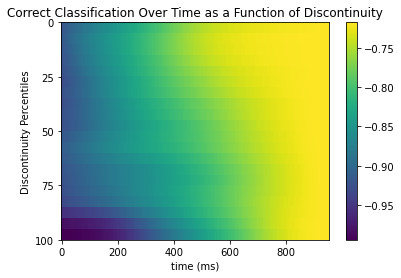

[34]
[18]
no


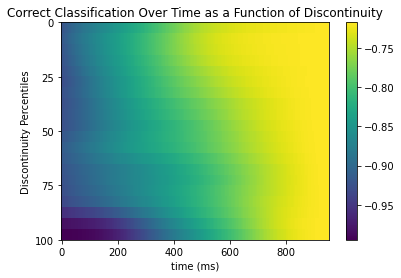

[34]
[18]
no


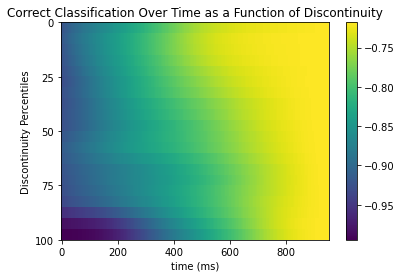

[18]
no


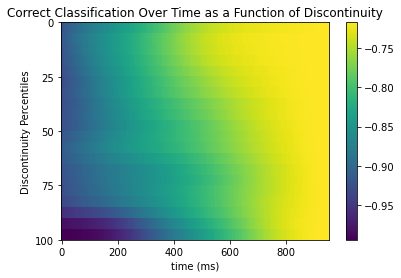

[18]
no


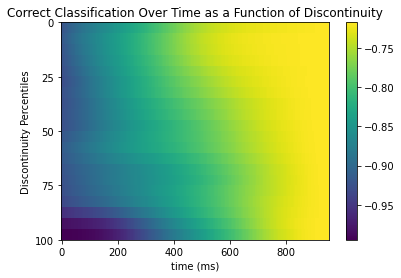

[34]
[18]
no


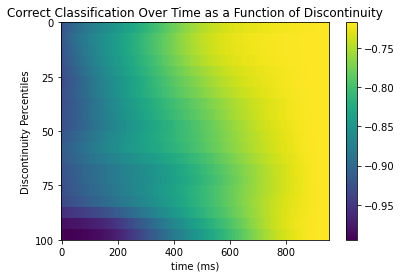

[34]
[34]
[18]
no


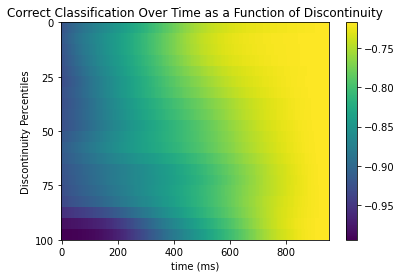

[18]
no


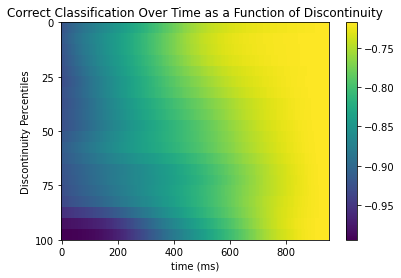

[34]
[18]
no


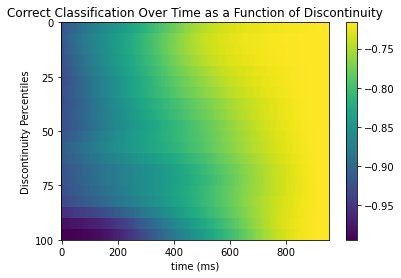

[34]
[34]
[18]
no


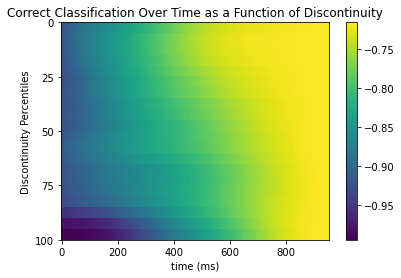

[18]
no


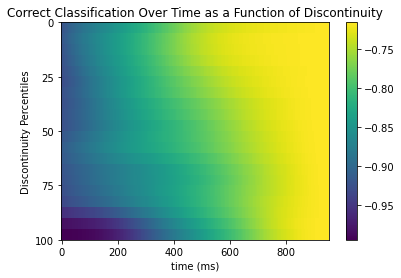

[34]
[34]
[34]
[18]
no


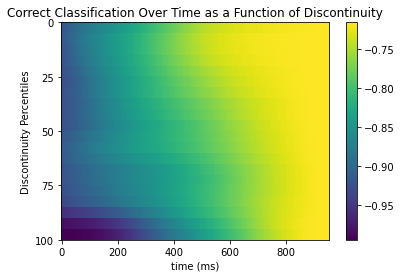

[34]
[34]
[34]
[34]
[34]
[18]
no


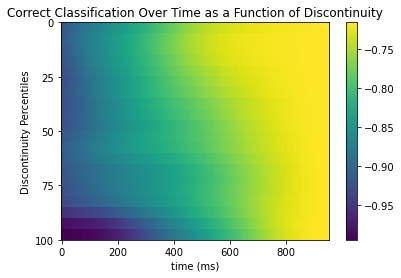

[18]
no


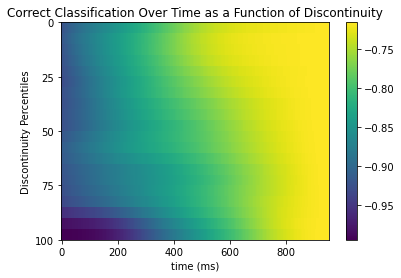

[34]
[34]
[34]
[34]
[18]
no


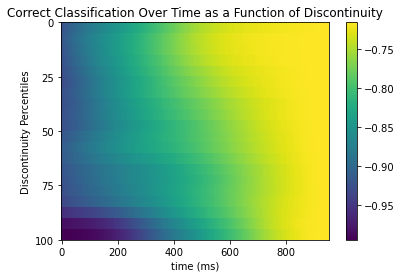

[34]
[34]
[18]
no


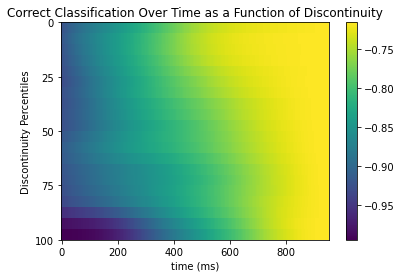

[34]
[34]
[34]
[18]
no


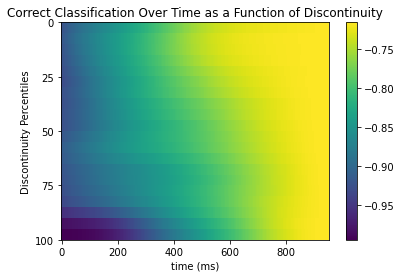

[34]
[18]
no


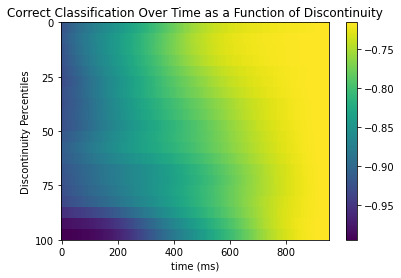

[18]
no


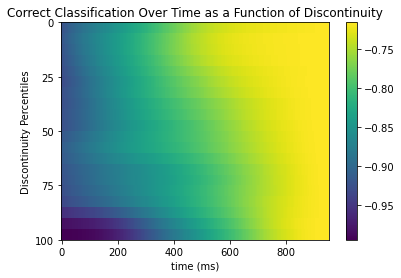

[18]
no


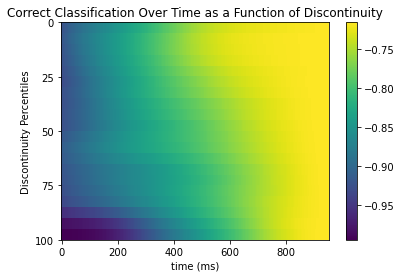

[34]
[34]
[18]
no


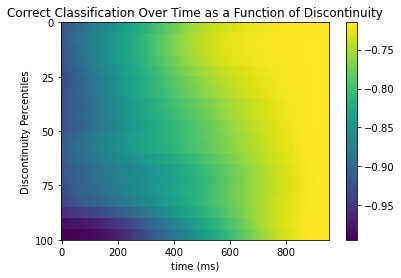

[34]
[34]
[34]
[34]
[18]
no


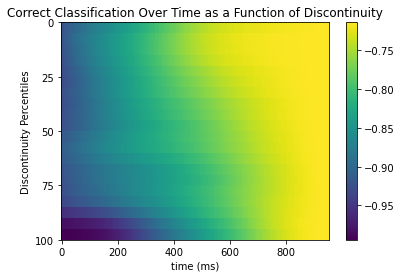

[34]
[34]
[34]
[18]
no


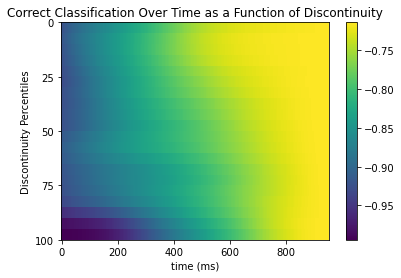

[18]
no


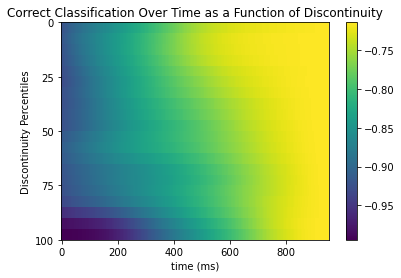

[34]
[34]
[18]
no


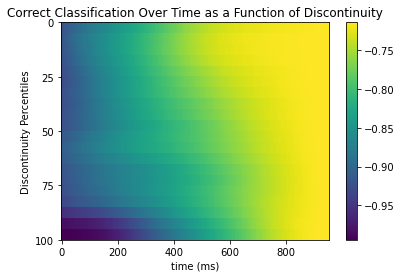

[18]
no


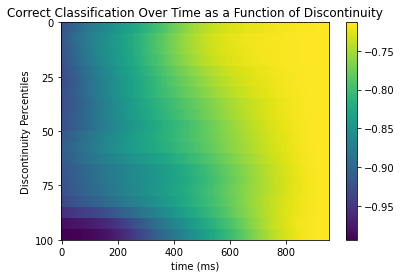

[18]
no


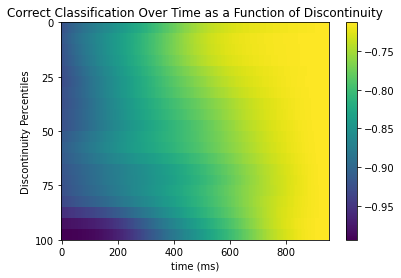

[18]
no


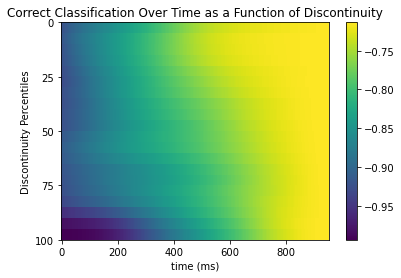

[18]
no


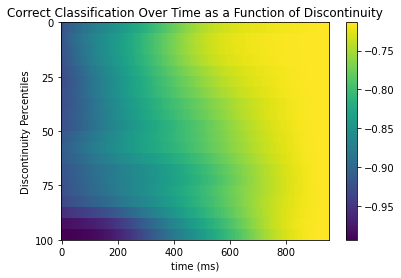

[34]
[34]
[34]
[18]
no


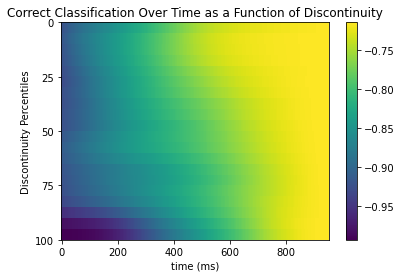

[18]
no


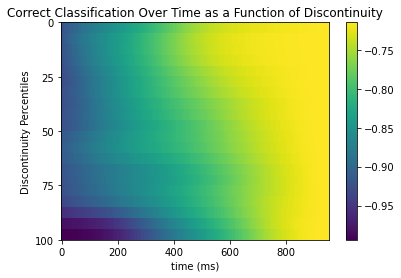

In [8]:
import os

def compileFileList(folder, file_prefix, file_data, class_dict):
    file_list = []
    for row in file_data:
        if row[-1] != 'train':
            squeezed_tgts = squeeze_tgts(row[1], tgt_classes, class_dict)
            if len(squeezed_tgts) != 0:
                comps = row[0].split('/')
                pickle_name = comps[0] + comps[1].split('.')[0] #for yes/no dataset
                #pickle_name = row[0].split('.')[0] #for FSD50K
                path = os.path.join(folder, file_prefix + pickle_name + '.pkl')
                file_list.append(path)
    return file_list

def findTMax(file_list):
    t_max = 0
    for path in file_list:
        gt = pickle.load(open(path, "rb"))
        sz = np.shape(gt[0])
        if sz[1] > t_max:
            t_max = sz[1]
    return t_max

def getTgtClassIds(class_dict):
    tgt_class_ids = []
    for tgt in tgt_classes:
        tgt_class_ids.append(class_dict[tgt])
    return tgt_class_ids

def compileAggregate(folder, file_prefix, csv_path, priming_file = None, analyze_tgts = []):
    """
    Compiles an aggregate of all future classification time series, sorted by their edginess.
    folder: string of the root folder of test gammatone files to use
    file_prefix: prefix used to denote gammatone files
    csv_path: path to file that contains all file names and their target classes and train/test split status
    priming_file: if priming is used to set the model into a certain state before producing a classification time-
    series, the file name without the prefix or file extension is given here
    analyze_tgts: 
    """
    (file_data, class_dict) = pickle.load(open(csv_path, "rb"))
    print(class_dict)
    file_list = compileFileList(folder, file_prefix, file_data, class_dict)
    fuzz_sz = 20
    t_max = findTMax(file_list)
    
    tgt_class_ids = getTgtClassIds(class_dict)
    print(tgt_class_ids)
    
    fuzz_arr = []
    
    for path in file_list:
        gt = pickle.load(open(path, "rb"))
        tgt_cl = gt[1]
        print(tgt_cl)
        class_name = ""
        for i in range(len(tgt_class_ids)):
            if tgt_class_ids[i] in tgt_cl:
                class_name = tgt_classes[i]
        if class_name == "":
            continue
        if len(analyze_tgts) != 0 and (class_name not in analyze_tgts):
            continue
        print(class_name)
        if priming_file is not None:
            priming_path = os.path.join(folder, file_prefix + priming_file + '.pkl')
        else:
            priming_path = None
        fut_cl = future_classification(path, class_name, priming_file = priming_path,
                              sample_max_t = t_max, plot=False, raw_wav = False)
        fuzz_cl = fuzzyResizeSquareMatrix(fut_cl, fuzz_sz)
        fuzz_arr.append(fuzz_cl)
        fuzz_avg = np.mean(fuzz_arr, axis=0)
        plt.imshow(fuzz_avg[:,:200], interpolation='nearest', aspect='auto')
        plt.xlabel('time (ms)')
        plt.ylabel('Discontinuity Percentiles')
        plt.xticks(ticks = [0, 40, 80, 120, 160], labels = [0, 200, 400, 600, 800])
        plt.yticks(ticks = [-0.5, 4.5, 9.5, 14.5, 19.5], labels = [0, 25, 50, 75, 100])
        plt.colorbar()
        plt.title('Correct Classification Over Time as a Function of Discontinuity')
        plt.show()
    return fuzz_arr
    
#fuzz_arr = compileAggregate('../speech_commands/gammatone/test', 'gammatone_', '../speech_commands/commands.pkl')
fuzz_arr = compileAggregate('../speech_commands/gammatone/test', 'gammatone_',
                            '../speech_commands/commands.pkl', priming_file = 'yesf2e59fea_nohash_1',
                           analyze_tgts=['no'])

In [12]:
def calcClassifImprove(t_class, t_end):
    return t_class[t_end] - t_class[0]

def ventileImprove(fuzz_arr, idx, t_end):
    improves = []
    for M_fuzz in fuzz_arr:
        improves.append(calcClassifImprove(M_fuzz[idx, :], t_end))
    return improves

improves_0 = ventileImprove(fuzz_arr, 0, 100)
improves_50 = ventileImprove(fuzz_arr, 9, 100)
improves_100 = ventileImprove(fuzz_arr, 19, 100)

%matplotlib qt5
plt.subplot(1, 3, 1)
plt.hist(improves_0, bins = 20)
plt.xlabel('classification improvement')
plt.ylabel('count')
plt.title('1st ventile')
plt.subplot(1, 3, 2)
plt.hist(improves_50, bins = 20)
plt.xlabel('classification improvement')
#plt.ylabel('count')
plt.title('10th ventile')
plt.subplot(1, 3, 3)
plt.hist(improves_100, bins = 20)
plt.xlabel('classification improvement')
#plt.ylabel('count')
plt.title('20th ventile')
#plt.suptitle('Distribution of average classification improvements', fontsize = 20)
plt.show()

In [10]:
from scipy.stats import wilcoxon

print(wilcoxon(improves_50, improves_100))
print(wilcoxon(improves_0, improves_100))
print(wilcoxon(improves_0, improves_50))

WilcoxonResult(statistic=32622.0, pvalue=0.0003184234675767594)
WilcoxonResult(statistic=34870.0, pvalue=0.008141248426162049)
WilcoxonResult(statistic=20911.0, pvalue=1.0527273508113286e-17)
